In [1]:
import requests
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm_notebook, tnrange
from bs4 import BeautifulSoup  
import warnings
import scipy.stats as stats
from joblib import dump, load
import pickle
import os

import tensorflow as tf

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import sklearn.exceptions
import imblearn.under_sampling as under_sampling
import imblearn.over_sampling as over_sampling
import imblearn.combine as combine
from imblearn.pipeline import make_pipeline as imb_make_pipeline
import imblearn.pipeline
from sklearn import ensemble, neighbors, linear_model, svm, naive_bayes, metrics, model_selection, preprocessing
from sklearn.tree import export_graphviz

import xgboost

sns.set_palette("Set2")
sns.set_context("notebook")

# Hit or Not?

**Objective**: We will use the Spotify [audio features data](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) to explore the characteristics of Billboard Hot 100 chart tracks between 2010 and 2018. We will also try to predict whether or not a randomly chosen track was on the chart using a binary classification algorithm.

The audio features are high-level descriptions of a song like danceability, energy, acousticness, tempo, and speechiness.

## Data Acquisition

### Billboard Hot 100 Tracks Data (2010-2018)

Scrape the Billboard Hot 100 Tracks (BB100) archive to acquire the song/artist that appeared in the Hot 100 at least once between 2010 and 2018. Create a data frame of artist name, song title, and the year.

We encode the level of popularity through a "rank score" (10 for 1st-10th, 9 for 11th-20th, etc.). Moreover, some tracks stayed on the BB100 for several weeks, so we put that information in the "nweeks" column. These two features are combined to create what a "popularity" measure, 

\begin{equation}
Pop = \sum_{r=1}^{R} rN_{r,\rm weeks}\;,
\end{equation}

where $r$ is the rank score ranging from 1 to 10 and $N_{\rm weeks}$ is the number of weeks the track has stayed on the BB100. A highly-ranked song that maintains its position has a high popularity score. In this metric, a song that was ranked between 1 and 10 for 1 week has the same score as a song that was ranked between 91 and 100 for 10 weeks. We can change this metric to give more weight to either attribute (super hit or staying power) depending on our priorities.

In [ ]:
redo = False
if redo:
    alltitles = []
    allartists = []
    years = []
    rscore = []
    ranknums = []
    ones = []
    for i in range(10)[::-1]:
        ranknums.extend([i+1]*10)
        
    year_list = [str(x) for x in range(2010,2019)]
    for i in tnrange(len(year_list), desc='Year'):
        
        year = year_list[i]
        page = requests.get("https://www.billboard.com/archive/charts/"+year+"/hot-100")
        soup = BeautifulSoup(page.content, "html.parser")
        
        all_dates = []
        for link in soup.select(".archive-table ")[0].find_all("a"):
            all_dates.append(link.get("href").split('/')[-1])
        
        for j in tnrange(len(all_dates), desc='Weeks', leave=False):
            page = requests.get("https://www.billboard.com/charts/hot-100/"+all_dates[j])
            soup = BeautifulSoup(page.content, "html.parser")
            
            artists_tags = soup.select(".chart-list-item .chart-list-item__artist")
            titles_tags = soup.find_all(class_='chart-list-item__title-text')
            
            assert len(artists_tags) == 100
            
            artists = [pt.get_text().replace("\n","").strip() for pt in artists_tags]
            titles = [pt.get_text().replace("\n","").strip() for pt in titles_tags]
            
            alltitles.extend(titles)
            allartists.extend(artists)
            
            years.extend([year]*100)
            rscore.extend(ranknums)
            ones.extend([1]*100)

        #make sure we're getting the expected number of items
                   
    bbhot100_orig = pd.DataFrame({"artists":allartists, "titles":alltitles, "year":years, "rankscore":rscore, "BBhot100":ones})
    bbhot100 = bbhot100_orig.copy()
    bbhot100 = bbhot100.groupby(bbhot100.columns.tolist()).size().reset_index()
    bbhot100.columns = ['nweeks' if x==0 else x for x in bbhot100.columns]
    
    print('Writing to a file.....')
    bbhot100.to_csv('bbhot100_checkpoint1.csv', index=False)
else:
    try:
        print('Reading in file.....')
        bbhot100 = pd.read_csv('bbhot100_checkpoint1.csv')
    except:
        print("The BBhot100 data file does not exist.")

Get the unique lists of songs and artists.

In [ ]:
print("There are {} unique BB Hot 100 hits.".format(len(np.unique(bbhot100.titles))))

In [ ]:
artists_w_bbhot100 = np.unique(bbhot100.artists)
print("There are {} unique artists with BB Hot 100 hits.".format(len(artists_w_bbhot100)))

Compute the popularity score and add to the bbhot100 data frame.

In [ ]:
popscore = bbhot100.groupby(['artists', 'titles', 'year']).apply(lambda x: sum(x.nweeks*x.rankscore))
popscore = popscore.reset_index()
popscore.columns = ['popscore' if x==0 else x for x in popscore.columns]

In [ ]:
bbhot100 = bbhot100.drop_duplicates(['artists', 'titles', 'year'])
bbhot100 = bbhot100.drop(columns=['rankscore', 'nweeks'])
bbhot100 = bbhot100.reset_index(drop=True)
assert popscore.shape == bbhot100.shape
bbhot100 = bbhot100.join(popscore['popscore'])

There are some songs that appeared on the chart over two years. We need to combine those into a single entry and correct for their popscore.

In [ ]:
dup = bbhot100.duplicated(subset=['artists', 'titles'], keep=False)
pairs = bbhot100[dup]

pairs_at = pairs[['titles', 'artists']].drop_duplicates()

In [ ]:
#loop through the unique set of artist & tracks with duplicates
for i, row in pairs_at.iterrows():
    #get all rows with the matching artist and tracks
    p_ind = pairs.index[(pairs['titles']==row['titles'])&(pairs['artists']==row['artists'])]
    #sum the total popscore, write to the first row, drop the duplicates
    popscore_total = sum(bbhot100['popscore'].loc[p_ind])
    bbhot100['popscore'].at[p_ind[0]] = popscore_total
    bbhot100 = bbhot100.drop(axis=0, index=p_ind[1:])

In [ ]:
bbhot100 = bbhot100.reset_index(drop=True)
bbhot100.head(n=10)

In [ ]:
if not Path('bbhot100_checkpoint2.csv').is_file():
    print('Writing to a file.....')
    bbhot100.to_csv('bbhot100_checkpoint2.csv', index=False)

### Spotify Data

#### BB100 song and artist data
Search the Spotify database for the artist and song ID and add the new resulting feature columns to our bbhot100 data frame. We utilize the [spotipy](https://spotipy.readthedocs.io/en/latest/#) package to access the Spotify Web API.

Some songs are collaborations between multiple artists. Use only the primary artist (first name listed) to search for the tracks. About 3% of the songs are not matched in the Spotify database mainly because the artist (e.g., Jay-Z, Taylor Swift until 2017) has not made the particular song available for streaming on Spotify. In a few cases, there are mismatches in name styling: we will not go through and manually check/change these cases.

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id='XXXXX', client_secret='XXXXX')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
redo = False
if redo:
    artists_sp_id = []
    tracks_sp_id = []
    join_chars = [' Featuring ', ' With ', ' Feauring ', ' / ', ' & ', ' x ', ' X ', ' + ', ' Duet ', ', ', ' And ', ' Vs ', ' vs ']
    
    for i_a in tnrange(len(bbhot100.artists), desc='BB100'):
                
        #try the artist name as is
        try:
            artist_query = bbhot100.artists[i_a]
            
            #avoiding manual intervention as much as possible.
            if artist_query == 'Ke$ha':
                artist_query = 'Kesha'
            if artist_query == 'ROCKMAFIA':
                artist_query = 'Rock Mafia'
            if artist_query == "Soulja Boy Tell'em":
                artist_query = 'Soulja Boy'
    
            artist = sp.search(q="artist:'"+artist_query+"'", type='artist', limit=1)
            aid = artist["artists"]["items"][0]["id"].strip()
            
            artists_sp_id.append(aid)
    
        except:
            for i_c, char in enumerate(join_chars):
                try:
                    #try a different version of the name
                    artist_query = bbhot100.artists[i_a].split(char)[0].strip()
                    artist = sp.search(q="artist:'"+artist_query+"'", type='artist', limit=1)
                    aid = artist["artists"]["items"][0]["id"].strip()
    
                    artists_sp_id.append(aid)
                    break
                except:
                    if i_c < (len(join_chars)-1):
                        continue
                    else:
                        print(i_a, artist_query, 'could not be matched in the Spotify database.')
                        artists_sp_id.append("9"*10)
            
        try:
            #sometimes the top returned result isn't actually the original song and instead is a cover, remix, etc.
            #choose the one with the highest popularity score according to Spotify out of three results
            track = sp.search(q="track:'"+bbhot100.titles[i_a]+"' artist:'"+artist_query+"'", type='track', limit=3)
            maxpopind = np.argmax([track['tracks']['items'][x]['popularity'] for x in range(len(track['tracks']['items']))])
            tracks_sp_id.append(track["tracks"]["items"][maxpopind]["id"].strip())
        except:
            try:
                track = sp.search(q="track:'"+bbhot100.titles[i_a].split('(')[0].strip()+"' artist:'"+artist_query+"'", type='track', limit=3)
                maxpopind = np.argmax([track['tracks']['items'][x]['popularity'] for x in range(len(track['tracks']['items']))])
                tracks_sp_id.append(track["tracks"]["items"][maxpopind]["id"].strip())
            except:
                try:
                    track = sp.search(q="track:'"+bbhot100.titles[i_a].split('-')[0].strip()+"' artist:'"+artist_query+"'", type='track', limit=3)
                    maxpopind = np.argmax([track['tracks']['items'][x]['popularity'] for x in range(len(track['tracks']['items']))])
                    tracks_sp_id.append(track["tracks"]["items"][maxpopind]["id"].strip())
                except:
                    try:
                        track = sp.search(q=bbhot100.titles[i_a]+" artist:'"+artist_query, type='track', limit=3)
                        maxpopind = np.argmax([track['tracks']['items'][x]['popularity'] for x in range(len(track['tracks']['items']))])
                        tracks_sp_id.append(track["tracks"]["items"][maxpopind]["id"].strip())
                    except:
                        print(i_a, bbhot100.titles[i_a], 'by', artist_query, 'could not be matched in the Spotify database.')
                        tracks_sp_id.append("9"*10)
    
    #save a unique list of IDs for artists with BB 100 hits
    allartists_sp_id = np.unique(artists_sp_id)
                    
    if len(artists_sp_id) == np.shape(bbhot100)[0]:
        bbhot100['artists_sid'] = artists_sp_id
        bbhot100['tracks_sid'] = tracks_sp_id
    else:
        print("Number of samples doesn't line up")
    
    print('Missing',sum((bbhot100.tracks_sid=='9'*10)|(bbhot100.artists_sid=='9'*10)),'out of',len(bbhot100.tracks_sid),'songs')
    
    #We will drop non-matches which comprise a small fraction of the whole sample.
    bbhot100 = bbhot100.drop(bbhot100[bbhot100.tracks_sid == '9'*10].index)
    bbhot100 = bbhot100.drop(bbhot100[bbhot100.artists_sid == '9'*10].index)
    bbhot100 = bbhot100.reset_index(drop=True)
    print('Missing',sum((bbhot100.tracks_sid=='9'*10)|(bbhot100.artists_sid=='9'*10)),'out of',len(bbhot100.artists_sid),'songs')

In [ ]:
if not Path('bbhot100_checkpoint3.csv').is_file():
    print('Writing to a file.....')
    bbhot100.to_csv('bbhot100_checkpoint3.csv', index=False)
else:
    print('Reading in file.....')
    bbhot100 = pd.read_csv('bbhot100_checkpoint3.csv')
    
if not Path('allartists_sp_id.csv').is_file():
    with open('allartists_sp_id.csv', 'w') as fname:
            wr = csv.writer(fname)
            for spid in allartists_sp_id:
                wr.writerow([spid])
else:
    with open('allartists_sp_id.csv', 'r') as fname:
        wr = csv.reader(fname)
        allartists_sp_id = [row[0] for row in wr] 

Use the Spotify track ids to obtain the ["Audio Features"](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) data, then change the data types from object to appropriate choices, and save to a csv.

In [ ]:
colnames2add = sp.audio_features(tracks=bbhot100.tracks_sid[0])[0].keys()
colnames2add = [x for x in colnames2add if x not in ['analysis_url','id','track_href','type','uri']]
bbhot100_af = pd.concat([bbhot100, pd.DataFrame(columns=colnames2add)], sort=False)           

In [ ]:
redo = False
if redo:
    for i_t in tnrange(len(bbhot100_af.artists), desc='Audio Features'):
    
        try:
            t = bbhot100_af.tracks_sid[i_t]
            audio_feats = sp.audio_features(tracks=t)[0]
            if audio_feats == None:
                continue
            [audio_feats.pop(x, None) for x in ['analysis_url','id','track_href','type','uri']]
            bbhot100_af.loc[i_t, colnames2add] = audio_feats.values()
        except:
            break
    
    bbhot100_af.dropna(inplace=True)
    int_cols = ['year', 'duration_ms', 'key', 'mode', 'time_signature', 'BBhot100']
    bbhot100_af[int_cols] = bbhot100_af[int_cols].astype('int')
    flt_cols = ['popscore', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']
    bbhot100_af[flt_cols] = bbhot100_af[flt_cols].astype('float')
    
    bbhot100_af = bbhot100_af.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    if not Path('bbhot100_checkpoint4.csv').is_file():
        print('Writing to a file.....')
        bbhot100_af.to_csv('bbhot100_checkpoint4.csv', index=False)
else:
    try:
        print('Reading in file.....')
        bbhot100_af = pd.read_csv('bbhot100_checkpoint4.csv')
    except:
        print("The BBhot100 data file does not exist.")
    

In [ ]:
bbhot100_af.head()

#### Other song and artist data

We obtain random songs on the Spotify database between 2010 and 2018 to achieve a ratio of 10:1 between non-hits and hits. There are two reasons for this choice. First, in a pool of randomly selected songs, hits are going to be very rare (10:1 is a gross underestimate). This is meant to at least weakly mimic the phenomenon. Second, we want to create a data set appropriate for applying machine learning on a very imbalanced data set (just for practice!).

Start with the data frame containing BB100 tracks and artists data.

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id='XXXXX', client_secret='XXXXX')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Obtain random tracks released between 2010-2018 and add to the new empty data frame.

In [ ]:
redo = False
if redo:
    num_it = 5000
    year_list = [str(x) for x in range(2010,2019)]
    
    row_list = []
    for y in tnrange(len(year_list), desc='Year'):    
        year = year_list[y]
        
        for i_l in tnrange(num_it, desc='Tracks', leave=False):
            
            #try to get a random song
            t = None
            while t == None:
                try:
                    #get a list of tracks released in a given year
                    random_int = random.randint(0, 10000)
                    tracks = sp.search(q="year:"+str(year), type='track', limit=1, offset=random_int)
                    t = tracks['tracks']['items'][0]
                    
                    #look up the audio features for the random track
                    audio_feats = sp.audio_features(tracks=t['id'])[0]
                    [audio_feats.pop(x, None) for x in ['analysis_url','id','track_href','type','uri']]
                    row = {'artists': t['artists'][0]['name'], 'titles': t['name'], 'year': year, \
                            'popscore': 0, 'artists_sid': t['artists'][0]['id'], 'tracks_sid': t['id'], \
                            **audio_feats, 'BBhot100':0}
                    row_list.append(row)
                except:
                    pass            
                
    non_bbhot100_af = pd.DataFrame(row_list)
    
    int_cols = ['year', 'duration_ms', 'key', 'mode', 'time_signature']
    non_bbhot100_af[int_cols] = non_bbhot100_af[int_cols].astype('int')
    flt_cols = ['popscore', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']
    non_bbhot100_af[flt_cols] = non_bbhot100_af[flt_cols].astype('float')
    
    non_bbhot100_af = non_bbhot100_af.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    non_bbhot100_af.dropna(inplace=True)
    
    if not Path('non_bbhot100_checkpoint1.csv').is_file():
        print('Writing to a file.....')
        non_bbhot100_af.to_csv('non_bbhot100_checkpoint1.csv', index=False)
else:
    try:
        non_bbhot100_af = pd.read_csv('non_bbhot100_checkpoint1.csv')
    except:
        print("The non_BBhot100 data file does not exist.")
        

In [ ]:
non_bbhot100_af.head()

In [ ]:
print('Number of non-hits: {}'.format(non_bbhot100_af.shape[0]))

#### Combining the two data sets
Combine the two data frames to get a mix of BB100 hit and non-hit songs.

In [ ]:
allsongs_af = pd.concat([bbhot100_af, non_bbhot100_af], sort=False)

Add one more feature column, 1 or 0 depending on if the artist has ever had a hit song on the BB100 chart between 2010 and 2018.

In [ ]:
allsongs_af['BBhot100_history'] = allsongs_af['artists_sid'].apply(lambda x: 1 if x in allartists_sp_id else 0)

Basic checks for duplicates, data types, NaNs, etc.

In [ ]:
print('Any duplicates? {}'.format(allsongs_af.duplicated().any()))
print('Number of duplicate songs:{:5}'.format(len(allsongs_af[allsongs_af.duplicated(keep='first')])))

if allsongs_af.duplicated().any():
    print('Removing duplicates.....')
    allsongs_af.drop_duplicates(inplace=True)
    
    print('Any duplicates? {}'.format(allsongs_af.duplicated().any()))
    print('Number of duplicate songs:{:4}'.format(len(allsongs_af[allsongs_af.duplicated(keep='first')])))

In [ ]:
count_null_values = allsongs_af.isnull().sum().sort_values(ascending=False)
print(count_null_values)
allsongs_af.dropna(inplace=True)

In [ ]:
allsongs_af.dtypes

In [ ]:
allsongs_af[['BBhot100', 'key', 'mode', 'time_signature', 'BBhot100_history']] = allsongs_af[['BBhot100', 'key', 'mode', 'time_signature', 'BBhot100_history']].astype('category')
allsongs_af.duration_ms = allsongs_af.duration_ms.astype(float)

In [ ]:
allsongs_af.dtypes

In [ ]:
allsongs_af.BBhot100.value_counts()

In [ ]:
if not Path('allsongs_af.csv').is_file():
    print('Writing to a file.....')
    allsongs_af.to_csv('allsongs_af.csv', index=False)
else:
    print('Reading in file.....')
    allsongs_af = pd.read_csv('allsongs_af.csv')

## Exploratory data analysis

Read in the data frame, drop the unnecessary columns, and shuffle the data.

In [2]:
df_0 = pd.read_csv('allsongs_af.csv')
df = df_0.drop(columns=['artists','titles','artists_sid','tracks_sid']).copy()
df = df.sample(frac=1).reset_index(drop=True)

df.head(n=10)

year  BBhot100  popscore  danceability  energy  key  loudness  mode  \
0  2017         0       0.0         0.836   0.961    7    -5.206     1   
1  2012         0       0.0         0.300   0.983    3    -5.271     0   
2  2017         0       0.0         0.463   0.927    5    -3.302     1   
3  2017         0       0.0         0.481   0.473    8    -5.844     1   
4  2013         0       0.0         0.780   0.669   11    -7.484     0   
5  2014         0       0.0         0.681   0.208    0   -14.483     0   
6  2015         0       0.0         0.611   0.543    1    -5.288     0   
7  2017         0       0.0         0.386   0.648    7    -6.645     0   
8  2011         0       0.0         0.459   0.989    4    -3.003     1   
9  2014         0       0.0         0.805   0.728    9    -6.296     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0445      0.141000          0.000396    0.1120    0.767  126.015   
1       0.2280      0.000243          0.000654    0.1160    0.152  125.983   
2       0.1590      0.486000          0.000000    0.3750    0.737  143.875   
3       0.0433      0.754000          0.000000    0.1350    0.492  133.048   
4       0.2380      0.381000          0.000005    0.0584    0.530   96.035   
5       0.0387      0.592000          0.004020    0.1170    0.156  130.021   
6       0.0672      0.329000          0.000000    0.2810    0.561  174.862   
7       0.0308      0.535000          0.000028    0.1190    0.251  180.073   
8       0.1620      0.003300          0.000316    0.1170    0.428  175.938   
9       0.0855      0.019300          0.240000    0.6170    0.638  112.024   

   duration_ms  time_signature  BBhot100_history  
0     266250.0               4                 0  
1     269280.0               4                 0  
2     319067.0               4                 0  
3     224213.0               4                 1  
4     251294.0               4                 0  
5     221864.0               4                 0  
6     189000.0               4                 0  
7     249127.0               4                 0  
8     249547.0               3                 0  
9     260920.0               4                 0

Check the distribution of hits and non-hits.

% of hits: 11.025


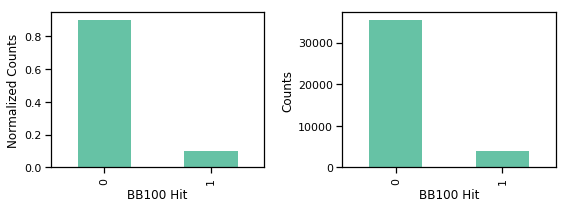

In [3]:
print('% of hits: {:5.3f}'.format(100*1.0*df.BBhot100.value_counts()[1]/df.BBhot100.value_counts()[0]))

plt.figure(1, figsize=(8,3))

plt.subplot(121)
df.BBhot100.value_counts(normalize=True).plot(kind='bar')
plt.ylabel('Normalized Counts')
plt.xlabel('BB100 Hit')

plt.subplot(122)
df.BBhot100.value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.xlabel('BB100 Hit')

plt.tight_layout()

Check the relationship between the features. These distributions are very far from normal. There are some outliers, like tempo = 0. They could be outputs from tracks where tempo couldn't be automatically measured. Use log(duration_ms) instead of duration_ms to get a more symmetric distribution.

Perhaps unsurprisingly, hits tend to be highly danceable, high energy, loud, non-instrumental, non-live-recordings.

We will *not* manually remove tracks with high instrumentalness from our analysis because they shouldn't be automatically ruled out (there have been some purely instrumental hits in the past). The sparsity of the data between 0.5 and 1.0 reflects the underlying population distribution (tracks with speechiness scores of nearly 1 are likely talk shows, audio books, or poetry). As Spotify describes, 

>Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

We will remove the samples above 0.66 because they are very likely not musical tracks at all.

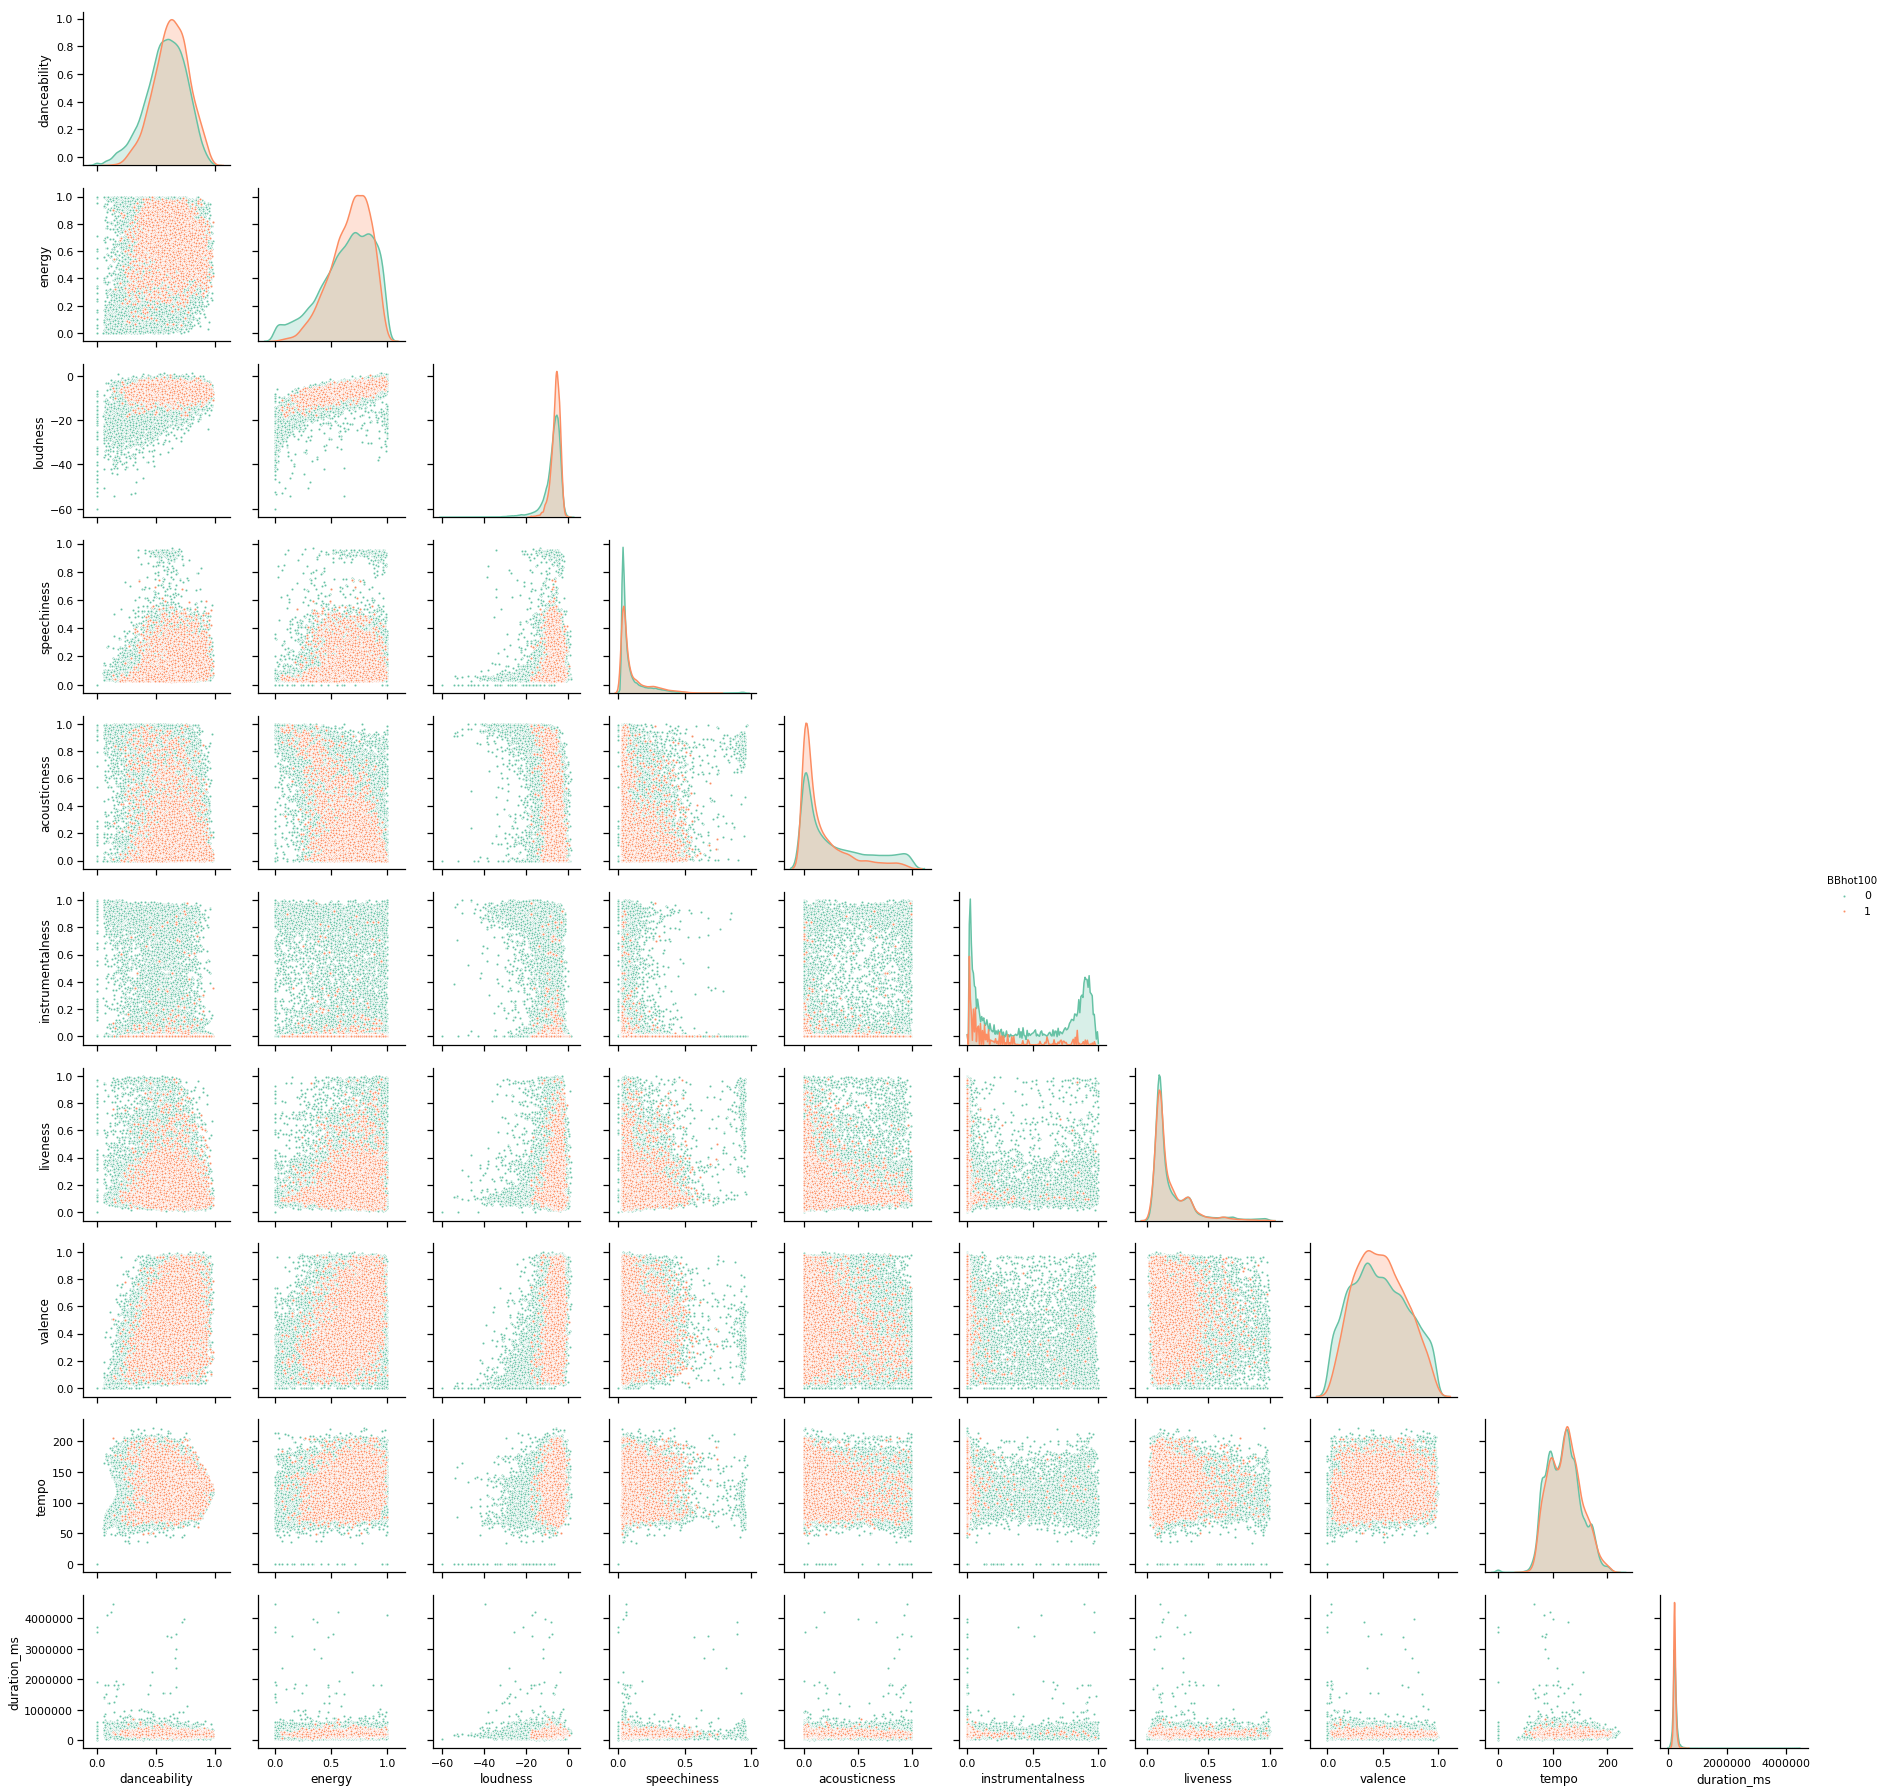

In [4]:
cont_feat_list = df.columns[df.dtypes==float].tolist()
cont_feat_list.remove('popscore')

s = sns.pairplot(df, vars=cont_feat_list, \
                 hue='BBhot100', plot_kws={"s": 8})
for i, j in zip(*np.triu_indices_from(s.axes, 1)):
    s.axes[i, j].set_visible(False)

In [5]:
df_losp = df[df.speechiness < 0.66].copy()
df_losp['duration_ms'] = df_losp['duration_ms'].apply(lambda x: np.log10(x))

The distributions of audio features for the hit songs are pretty broad, and there's a lot of overlap in the marginalized distributions between hits and non-hits. What if we only looked at the "mega-hits" according to our popularity metric? Let's look at the distribution of popscores for our hit songs, a metric that combines both its ranking on the BB100 chart and the durability of its popularity.

Text(0.5, 0, 'log(popscore)')

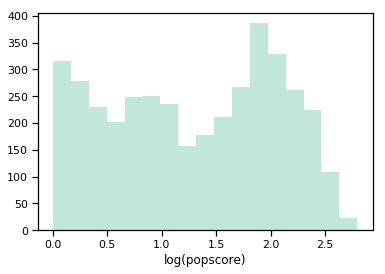

In [6]:
s = sns.distplot(np.log10(df_losp[df_losp.BBhot100 == 1]['popscore']), kde=False)
s.set_xlabel("log(popscore)")

A cut at popscore = 100 would yield the top ~20% of the tracks.

Text(0, 0.5, 'CDF')

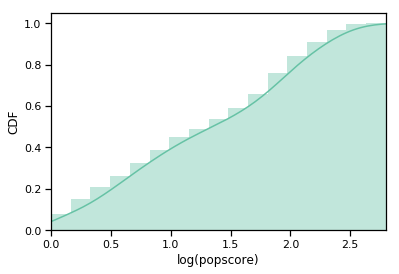

In [7]:
s = sns.distplot(np.log10(df_losp[df_losp.BBhot100 == 1]['popscore']),\
                 hist_kws={'cumulative':True},\
             kde_kws={'cumulative':True})
s.set_xlim(0, max(np.log10(df_losp[df_losp.BBhot100 == 1]['popscore'])))
s.set_xlabel("log(popscore)")
s.set_ylabel("CDF")

These are the top 10 songs with the highest popscores. Based on a few spot checks, these are not all necessarily the mega-hits at #1 on the charts. For example, while ["Diamonds" by Rihanna](https://www.billboard.com/music/rihanna/chart-history/hot-100/song/759536) peaked at #1 (and stayed there for 3 weeks) but spent only 26 weeks overall on the chart, ["Thunder" by Imagine Dragons](https://www.billboard.com/music/imagine-dragons/chart-history/hot-100/song/1024087) peaked at only #4 but remained on the chart for a whopping 52 weeks.

In [8]:
df_losp[df_losp.BBhot100==1].sort_values('popscore', ascending=False).head(n=10)

year  BBhot100  popscore  danceability  energy  key  loudness  mode  \
31444  2012         1     627.0         0.448   0.784    9    -3.686     1   
26847  2011         1     556.0         0.750   0.727    5    -4.210     0   
23008  2017         1     546.0         0.825   0.652    1    -3.183     0   
38228  2013         1     539.0         0.664   0.705    1    -4.972     0   
22720  2010         1     515.0         0.729   0.756    8    -5.119     1   
12391  2014         1     514.0         0.856   0.609    0    -7.223     1   
7881   2017         1     502.0         0.599   0.448    8    -6.312     1   
1042   2012         1     488.0         0.857   0.517    0    -6.972     1   
25223  2013         1     481.0         0.645   0.585    6    -6.122     1   
25554  2014         1     468.0         0.781   0.445    2    -6.061     1   

       speechiness  acousticness  instrumentalness  liveness  valence  \
31444       0.0627       0.10600          0.000108    0.6680    0.236   
26847       0.1420       0.01890          0.000000    0.2660    0.359   
23008       0.0802       0.58100          0.000000    0.0931    0.931   
38228       0.0382       0.06540          0.000000    0.1150    0.477   
22720       0.0294       0.13100          0.000000    0.0527    0.522   
12391       0.0824       0.00801          0.000081    0.0344    0.928   
7881        0.0232       0.16300          0.000000    0.1060    0.168   
1042        0.0384       0.56500          0.000195    0.1020    0.754   
25223       0.0513       0.00314          0.000000    0.1650    0.353   
25554       0.0295       0.47400          0.000000    0.1840    0.591   

         tempo  duration_ms  time_signature  BBhot100_history  
31444  136.245     5.271407               4                 1  
26847  129.993     5.418588               4                 1  
23008   95.977     5.368683               4                 1  
38228  122.017     5.411350               4                 1  
22720  104.945     5.358493               4                 1  
12391  114.988     5.430828               4                 1  
7881    95.050     5.420616               3                 1  
1042   129.063     5.389118               4                 1  
25223  131.931     5.333794               4                 1  
25554   78.998     5.449571               4                 1

The feature distributions of mega-hits are definitely tighter and occupy distinct parts of the feature space, but the distributions of hits and non-hits definitely overlap. This would be a challenging classification problem.

In [9]:
df_hits = df_losp.copy()
df_hits['Megahit'] = df_hits['popscore'].apply(lambda x: 1 if x >= 100.0 else 0)

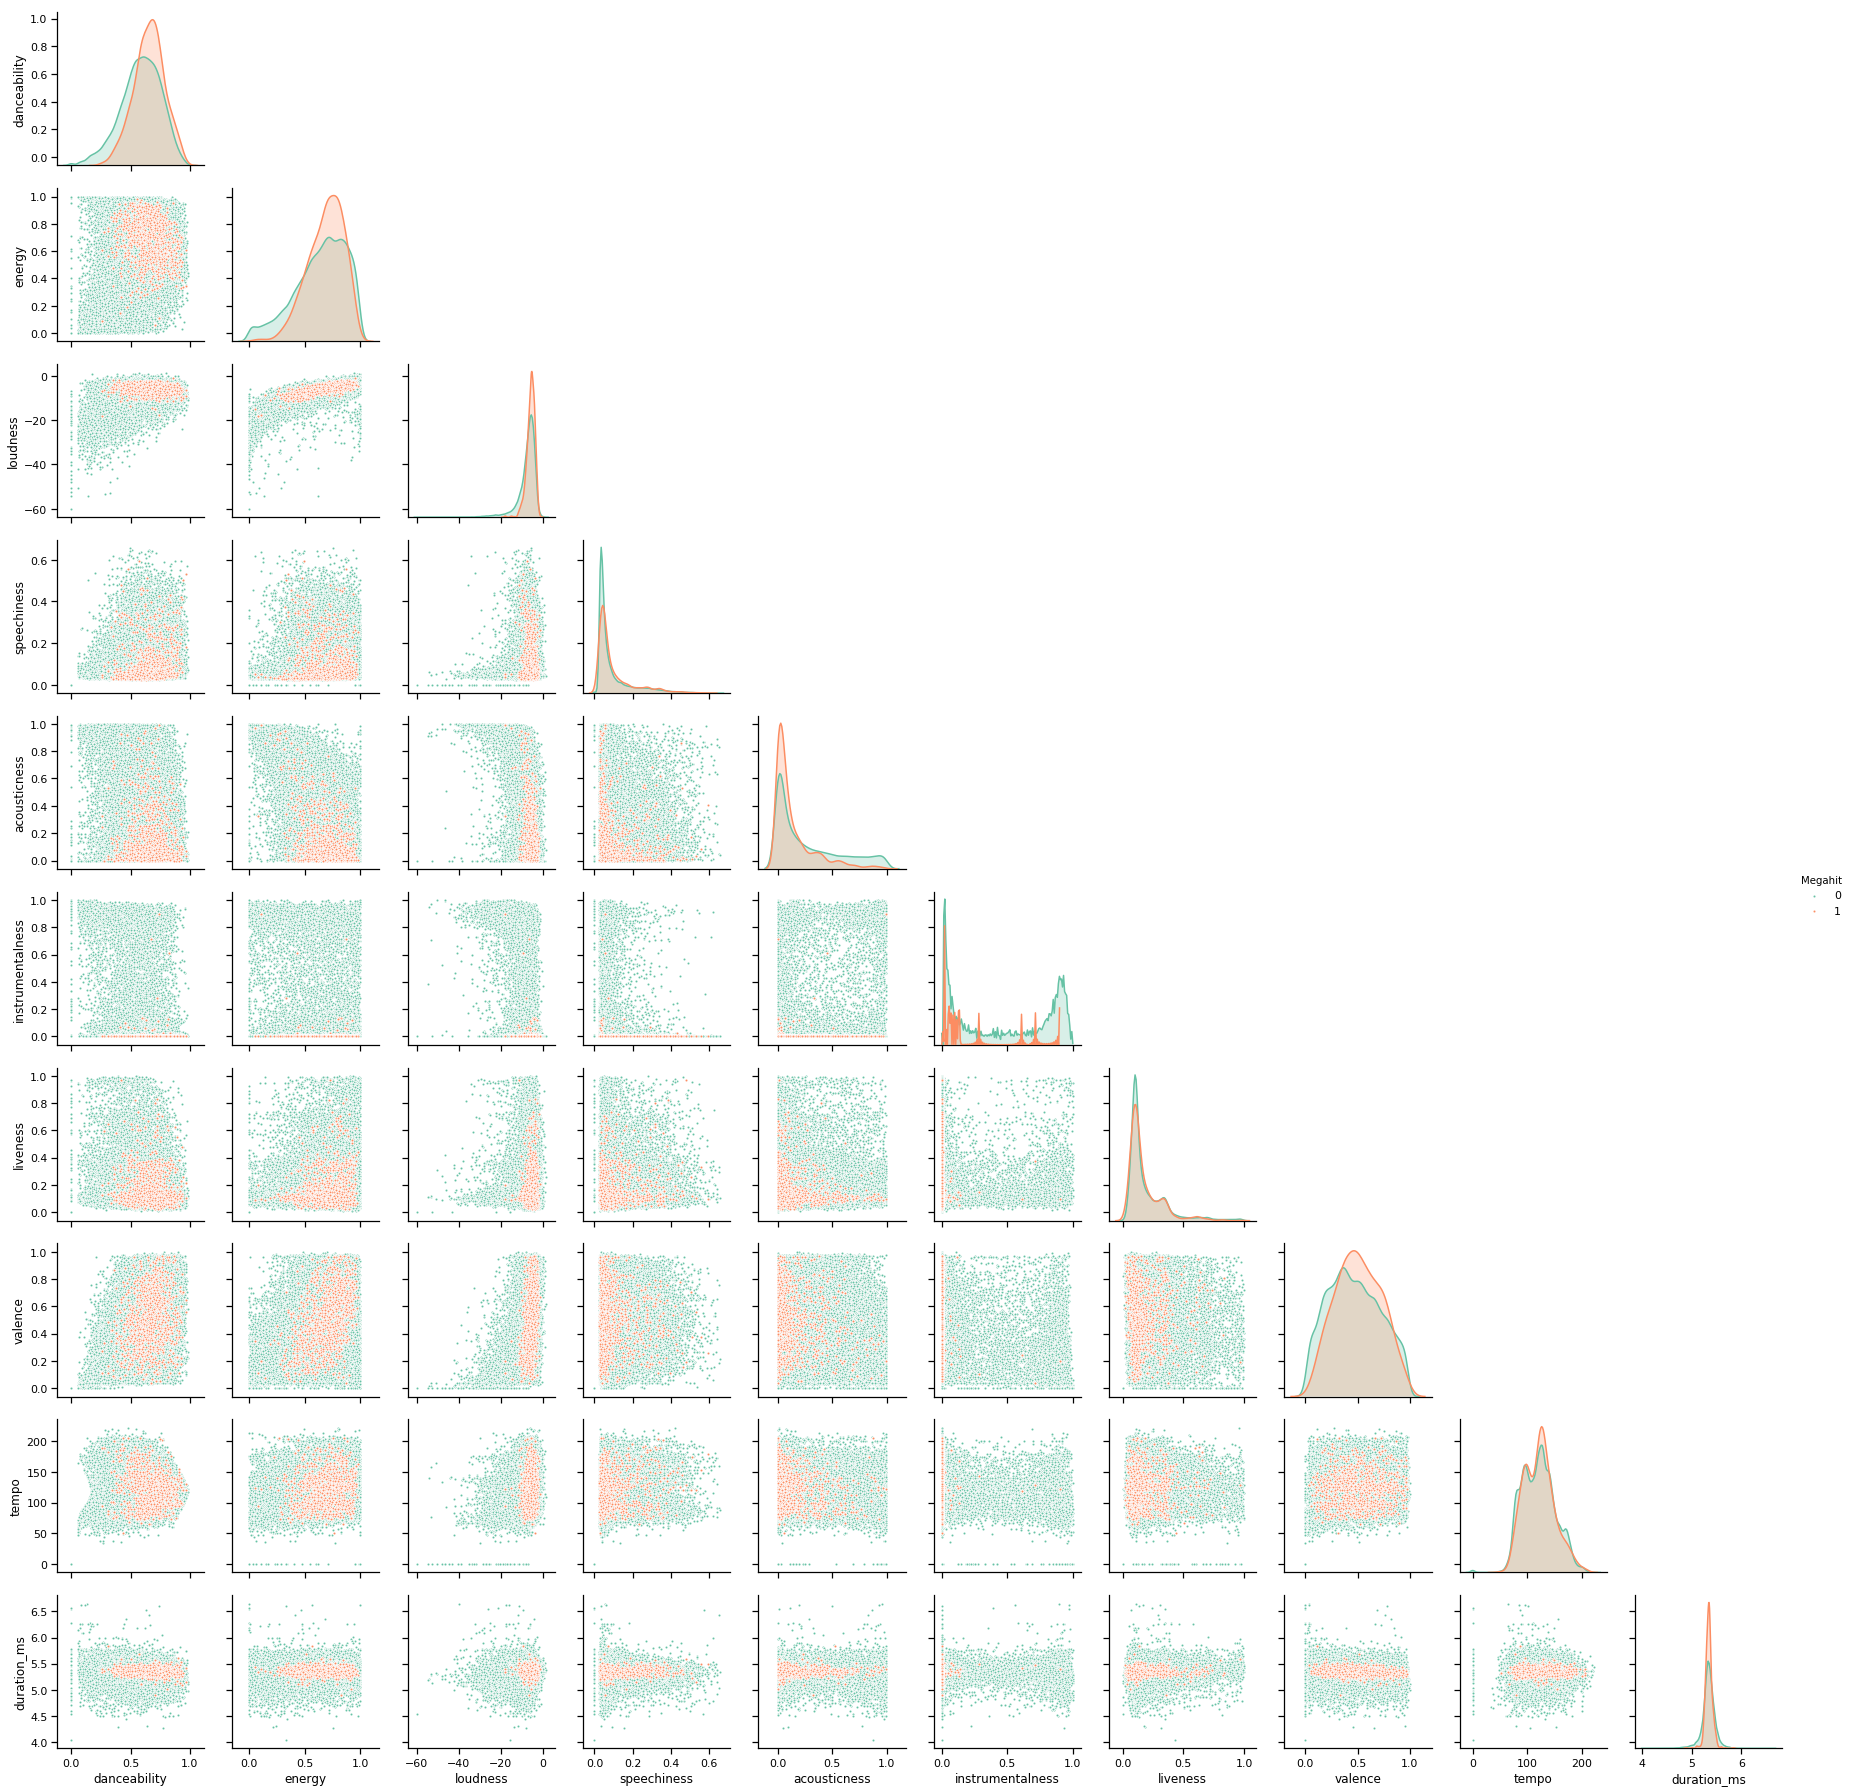

In [10]:
s = sns.pairplot(df_hits, vars=cont_feat_list, \
                 hue='Megahit', plot_kws={"s": 8})
for i, j in zip(*np.triu_indices_from(s.axes, 1)):
    s.axes[i, j].set_visible(False)

Just looking at the continuous features, some (e.g., energy and acousticness) look mildly correlated.

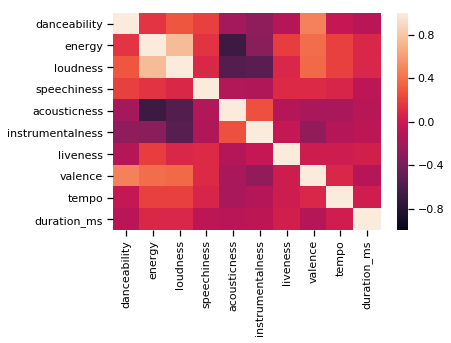

In [11]:
s = sns.heatmap(df_losp[cont_feat_list].corr(), vmin=-1, vmax=1)

Let's continue with trying to classify the mega-hits.

In [12]:
df_mh = df_losp[(df_losp.popscore > 100.0)&(df_losp.BBhot100 == 1)|(df_losp.BBhot100 == 0)].copy()

Now examine the categorical features. They don't seem to be very good predictors of the hits. The distribution of modes is very similar. But it is interesting that hit songs show very little variation in time signatures.

In [13]:
cat_feat_list = df_mh.columns[df_mh.dtypes!=float].tolist()
[cat_feat_list.remove(x) for x in ['BBhot100', 'BBhot100_history', 'year']]

[None, None, None]

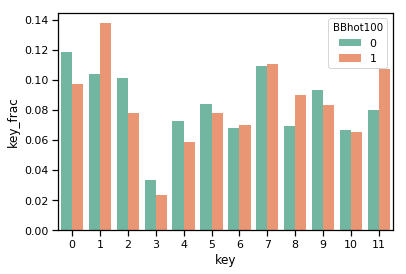

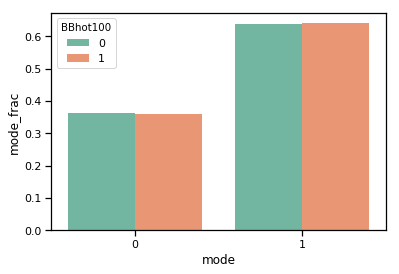

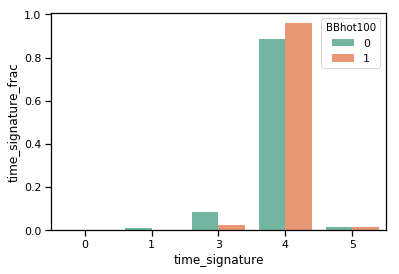

In [14]:
for c in cat_feat_list:
    df_cat_tmp = (df_mh[c]
               .groupby(df_mh['BBhot100'])
               .value_counts(normalize=True)
               .rename(c+'_frac')).reset_index()
    plt.figure()
    s = sns.barplot(x=c, y=c+'_frac', hue='BBhot100', data=df_cat_tmp)

Here we check to see if there are any interesting trends with time. There appears to be some very weak evidence for hit songs trending away from extremely loud, high-energy, and high-valence characteristics (think Taio Cruz's "Dynamite" circa 2010) with time. Here, valence corresponds to "musical positiveness", where valence=1 evokes happy and/or cheerful thoughts whereas valence=0 evokes sad and/or angry feelings. Hit songs still tend to score strongly on the danceability spectrum.

**SHOULD REVISIT AND EXPLORE FURTHER!**

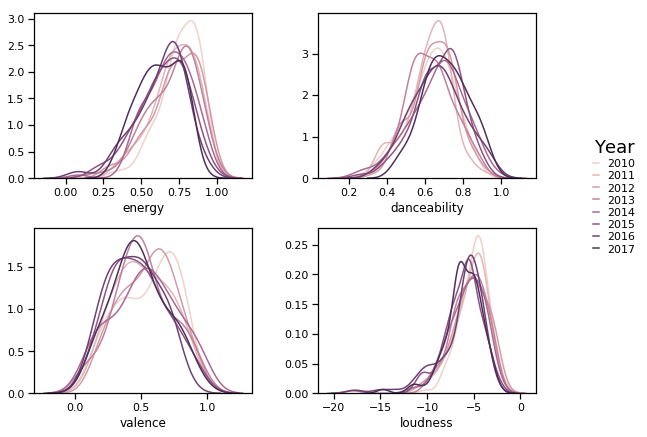

In [15]:
feat_list = ['energy', 'danceability', 'valence', 'loudness']
sns.set_palette(sns.cubehelix_palette(9))
plt.figure(1, figsize=(9,7))
for i_f, f in enumerate(feat_list):
    plt.subplot('22'+str(i_f+1))
    for y in range(2010, 2018):
        s = sns.kdeplot(df_mh[(df_mh.year == y)&(df_mh.BBhot100 == 1)][f])
        s.set_xlabel(f)

    if i_f == 1:
        s.axes.legend(frameon=False, labelspacing=0.2, handlelength=0.5, bbox_to_anchor=(1.5, 0.3), title_fontsize=18)
        leg = s.axes.get_legend()
        leg.set_title('Year')
        new_labels = [str(x) for x in range(2010, 2018)]
        for t, l in zip(leg.texts, new_labels):
            t.set_text(l)

    else:
        leg = s.axes.get_legend().remove()

plt.subplots_adjust(wspace=0.3, hspace=0.3)

## Dealing with an Imbalanced Data Set

Our target label (1 or 0) is highly imbalanced, where BBhot100=True=1 constitutes only about 10% of the entire data set. Other examples of classification of imbalanced data include fraud detection and screening for rare diseases. 

There are several things we need to keep in mind when working with imbalanced data. The classifier will be biased towards the majority class (the non-hits in our example), and simple metrics such as accuracy are woefully insufficient when evaluating different models (i.e., a classifier that labels all songs as non-hits will be accurate 10% of the time in our example).

There are two approaches to dealing with an imbalanced data set. The first approach focuses on carefully choosing and modifying different classification algorithms to properly treat the imbalanced data sets. For example, sklearn allows the user to provide a ``class_weight`` parameter to classifiers such as SVC and LR. The second approach focuses on resampling the data prior to fitting models. We will test several resampling strategies, including very simple methods such as random over- and undersampling, as well as more sophisticated methods such as SMOTE (synthetic minority oversampling technique).

### Rescaling

First, ensure that all of the features are on a similar scale before we proceed with resampling and fitting.

In [16]:
for c in df_mh.columns:
    print(c+':', min(df_mh[c]), max(df_mh[c]))

year: 2010 2018
BBhot100: 0 1
popscore: 0.0 627.0
danceability: 0.0 0.985
energy: 0.0 1.0
key: 0 11
loudness: -60.0 1.484
mode: 0 1
speechiness: 0.0 0.655
acousticness: 0.0 0.996
instrumentalness: 0.0 1.0
liveness: 0.0 0.998
valence: 0.0 1.0
tempo: 0.0 222.133
duration_ms: 4.036868329981055 6.651136263516497
time_signature: 0 5
BBhot100_history: 0 1


Split the data frame into into train and test data sets and drop the target label. Also drop the popscore and BBhot100_history since they essentially encode the BBhot100 information directly.

In [17]:
df_orig_train, df_final_test = model_selection.train_test_split(df_mh, test_size=0.3, stratify=df_mh.BBhot100)

Scale the values. We rescale the features separately since we want to retain the integer type for some of our features for resampling later.

In [18]:
scale_ind = [np.ravel(np.where(df_orig_train.columns.values == x))[0] for x in ['loudness', 'tempo']]

sc = preprocessing.MinMaxScaler()
sc.fit(df_orig_train.iloc[:,scale_ind])

df_orig_train_sc_1 = pd.DataFrame(sc.transform(df_orig_train.iloc[:,scale_ind]), \
                                index=df_orig_train.index, columns = df_orig_train.iloc[:,scale_ind].columns)
df_final_test_sc_1 = pd.DataFrame(sc.transform(df_final_test.iloc[:,scale_ind]), \
                                index=df_final_test.index, columns = df_final_test.iloc[:,scale_ind].columns)

Save for later use.

In [19]:
with open("scaler.pickle", "wb") as handle:
    pickle.dump(sc, handle)

Combine with the other columns.

In [20]:
noscale_ind = [np.ravel(np.where(df_orig_train.columns.values == x))[0] for x in df_orig_train.columns.values if x not in ['loudness', 'tempo', 'duration_ms'] ]

df_orig_train_sc = pd.concat([df_orig_train.iloc[:,noscale_ind], df_orig_train_sc_1], axis=1)
df_final_test_sc = pd.concat([df_final_test.iloc[:,noscale_ind], df_final_test_sc_1], axis=1)

Separate features and label.

In [21]:
orig_train_y = df_orig_train_sc.BBhot100.copy()
orig_train_X = df_orig_train_sc.drop(columns=['BBhot100', 'popscore', 'BBhot100_history', 'year'])
final_test_y = df_final_test_sc.BBhot100.copy()
final_test_X = df_final_test_sc.drop(columns=['BBhot100', 'popscore', 'BBhot100_history', 'year'])

Some checks before proceeding.

In [22]:
orig_train_X.describe()

danceability        energy           key          mode   speechiness  \
count  25281.000000  25281.000000  25281.000000  25281.000000  25281.000000   
mean       0.583453      0.637812      5.232388      0.638187      0.091727   
std        0.170235      0.234076      3.597158      0.480535      0.093542   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.478000      0.491000      2.000000      0.000000      0.036000   
50%        0.596000      0.674000      5.000000      1.000000      0.051300   
75%        0.708000      0.825000      8.000000      1.000000      0.101000   
max        0.982000      1.000000     11.000000      1.000000      0.655000   

       acousticness  instrumentalness      liveness       valence  \
count  25281.000000      25281.000000  25281.000000  25281.000000   
mean       0.287821          0.099937      0.195222      0.470522   
std        0.306568          0.256847      0.161058      0.249081   
min        0.000000          0.000000      0.000000      0.000000   
25%        0.024400          0.000000      0.097900      0.273000   
50%        0.161000          0.000007      0.128000      0.455000   
75%        0.494000          0.002970      0.248000      0.666000   
max        0.996000          1.000000      0.994000      0.993000   

       time_signature      loudness         tempo  
count    25281.000000  25281.000000  25281.000000  
mean         3.893280      0.852845      0.543163  
std          0.461152      0.075421      0.135077  
min          0.000000      0.000000      0.000000  
25%          4.000000      0.833420      0.436369  
50%          4.000000      0.870844      0.540320  
75%          4.000000      0.897486      0.630375  
max          5.000000      1.000000      1.000000

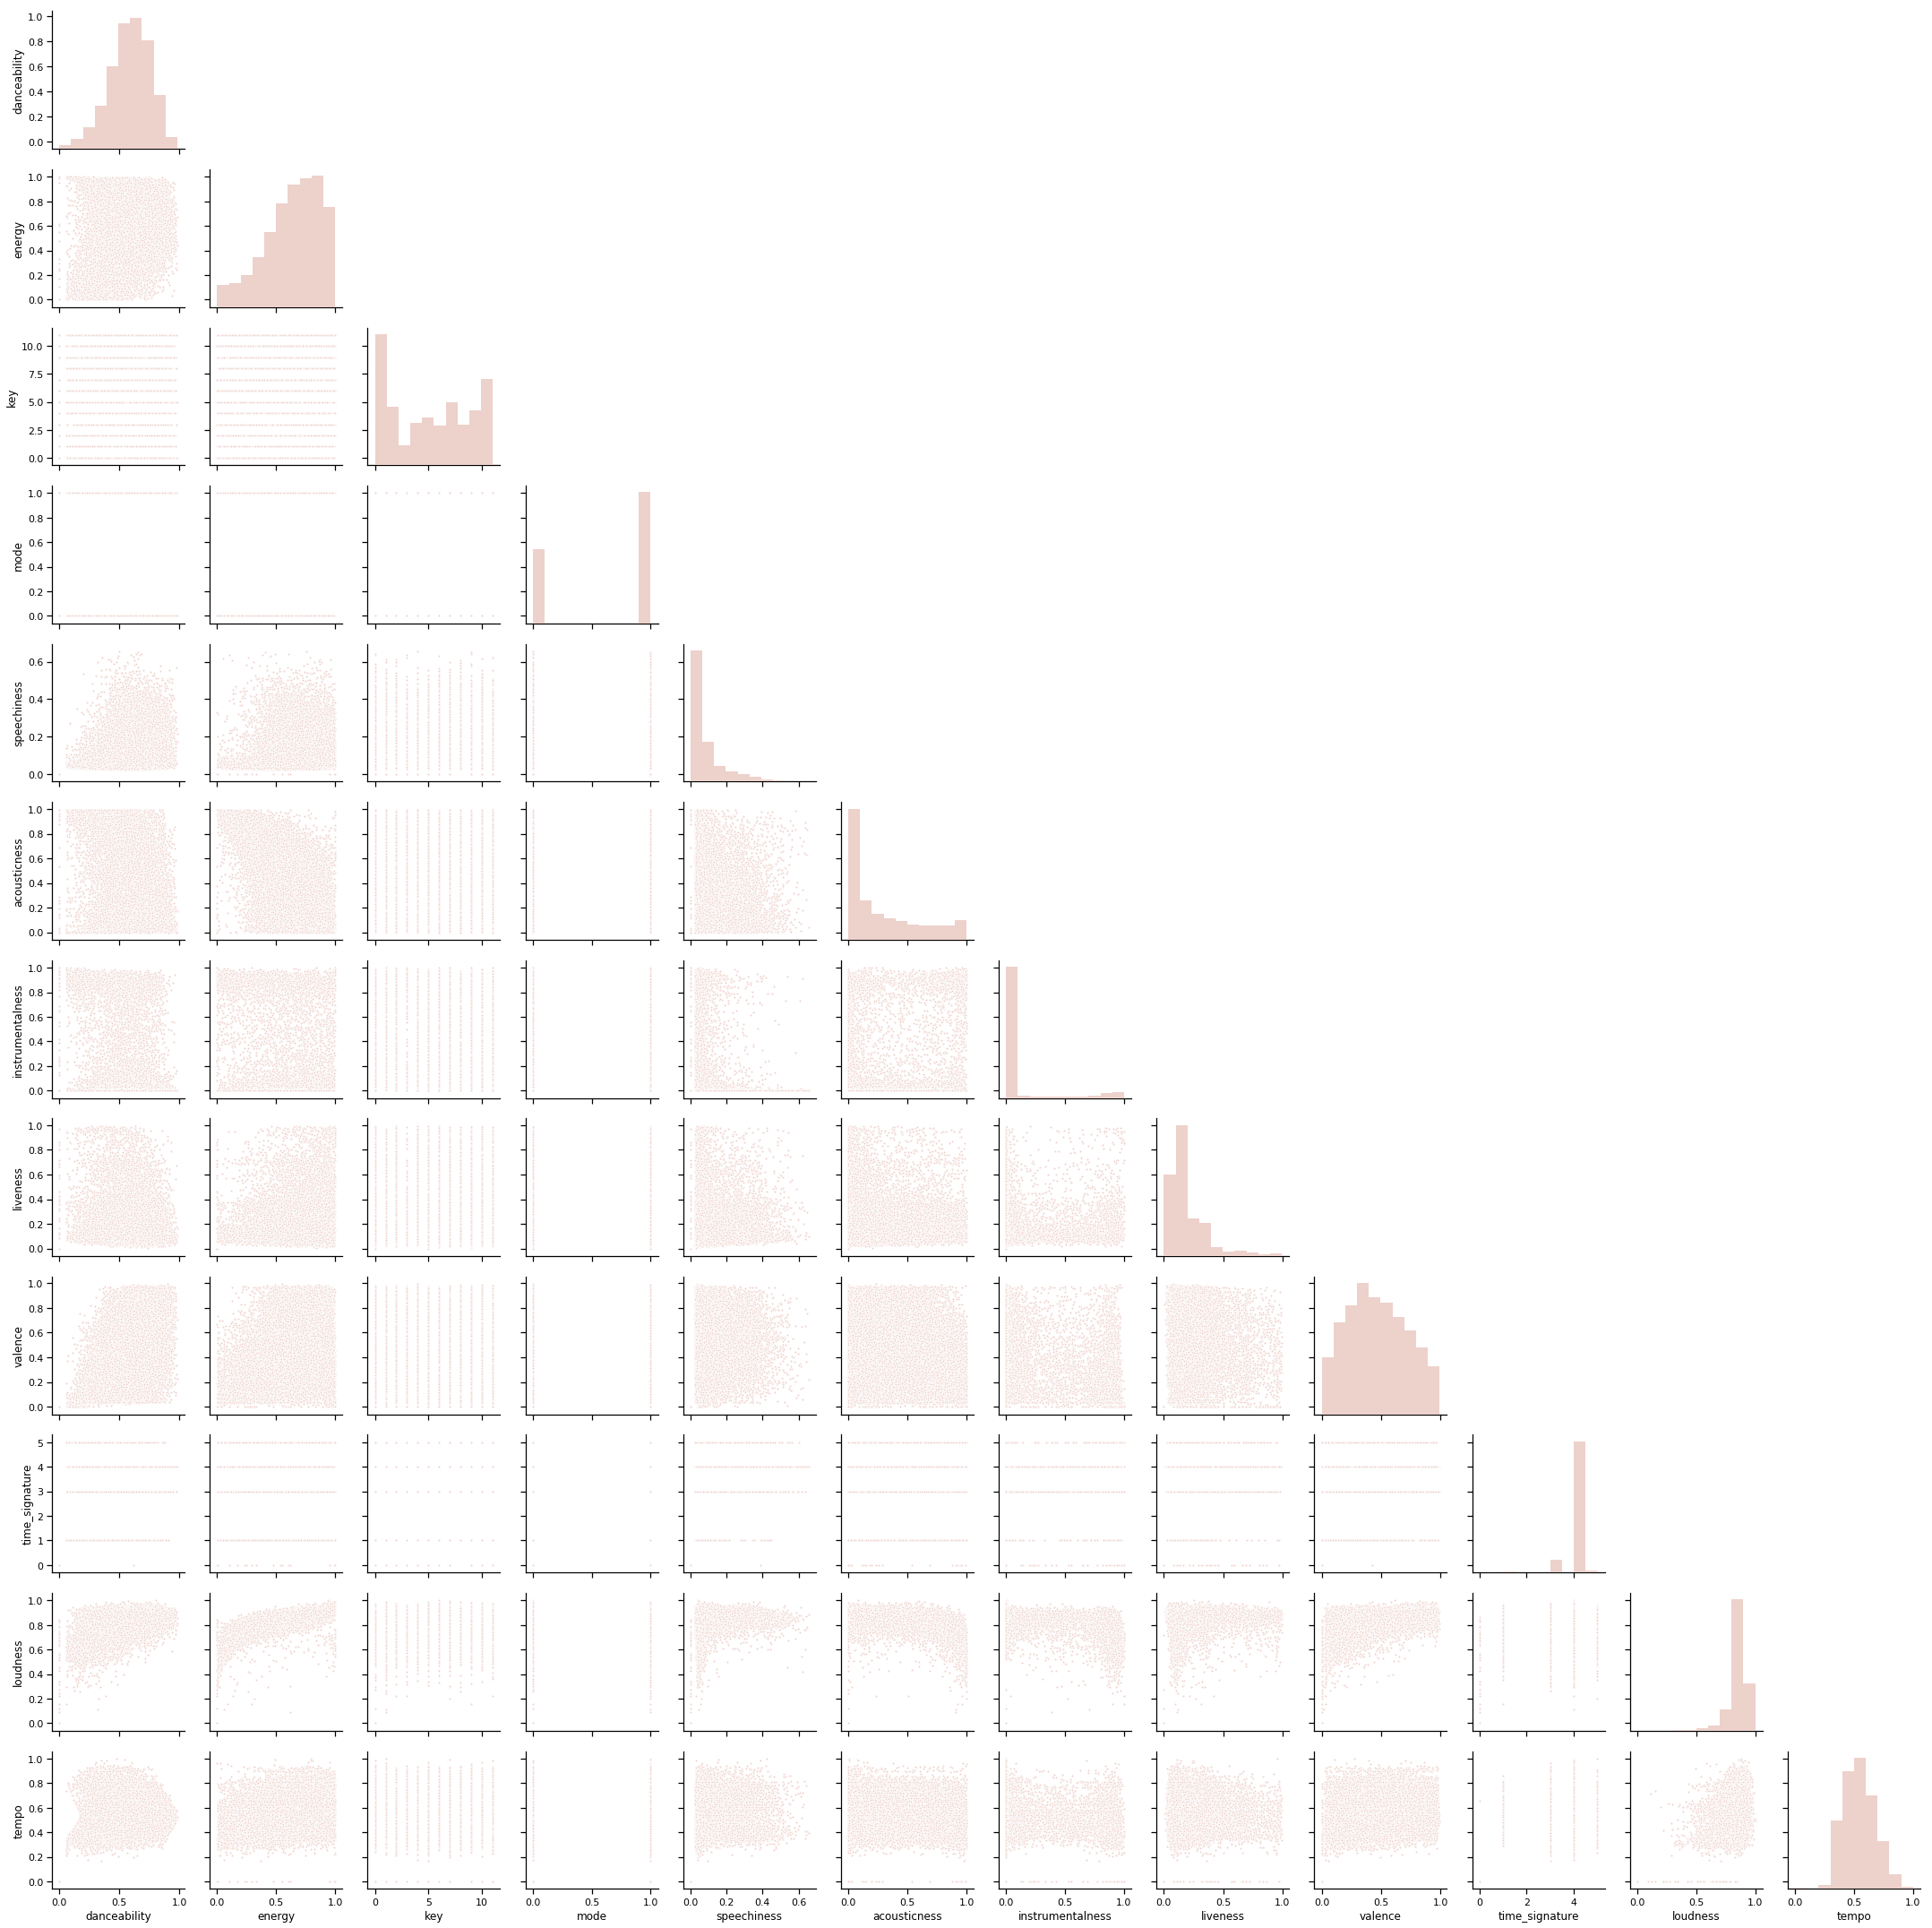

In [23]:
s = sns.pairplot(orig_train_X, plot_kws={"s": 8})
for i, j in zip(*np.triu_indices_from(s.axes, 1)):
    s.axes[i, j].set_visible(False)

### Baseline with Naive Bayes Without Resampling.

Let's go ahead and fit our data with a Naive Bayes.

Just to remind ourselves...

$\rm Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$\rm Precision = \frac{TP}{TP+FP}$

$\rm Recall = \frac{TP}{TP+FN}$

(array([ 541., 1308.,  587.,  966., 1186.,  507.,  907.,  288.,   20.,
          11.]),
 array([0.02086589, 0.0218601 , 0.02285431, 0.02384852, 0.02484272,
        0.02583693, 0.02683114, 0.02782535, 0.02881955, 0.02981376,
        0.03080797]),
 <a list of 10 Patch objects>)

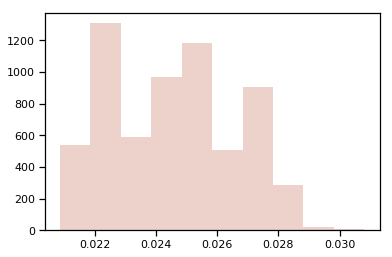

In [24]:
#as predicted before, categorical features are useless. we will drop them.
X_train, X_test, y_train, y_test = model_selection.train_test_split(orig_train_X, orig_train_y,\
                                                                    test_size=0.25, stratify=orig_train_y)
clf_mnb = naive_bayes.MultinomialNB()
cat_feat = X_train.columns[X_train.dtypes != float]
clf_mnb.fit(X_train[cat_feat], y_train)

prob_mnb = clf_mnb.predict_proba(X_test[cat_feat])
plt.hist(prob_mnb[:,1])

In [25]:
orig_train_X = orig_train_X.drop(columns=cat_feat)
final_test_X = final_test_X.drop(columns=cat_feat)

In [26]:
stkfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

acc_list = []
pre_list = []
rec_list = []
for train_ind, test_ind in stkfold.split(orig_train_X, orig_train_y):
    train_X, train_y, test_X, test_y = orig_train_X.iloc[train_ind], orig_train_y.iloc[train_ind], orig_train_X.iloc[test_ind], orig_train_y.iloc[test_ind]
    
    #apply NB to continuous features only
    clf_gnb = naive_bayes.GaussianNB()
    clf_gnb.fit(train_X, train_y)
    pred_y = clf_gnb.predict(test_X)
    
    acc_list.append(metrics.accuracy_score(test_y, pred_y))
    pre_list.append(metrics.precision_score(test_y, pred_y))
    rec_list.append(metrics.recall_score(test_y, pred_y))

print('Model accuracy: {:5.3f}'.format(np.mean(acc_list)))
print('Precision: {:5.3f}'.format(np.mean(pre_list)))
print('Recall: {:5.3f}'.format(np.mean(rec_list)))

print('If we always guess 0, Accuracy: {:5.3f}'.format(sum((test_y == 0)*1.0)*1.0/len(test_y))) #reduces to TN/(TN+FN)
print('If we always guess 0, Precision: {:5.3f}'.format(0)) #0 divided by anything is 0
print('If we always guess 0, Recall: {:5.3f}'.format(0)) #0 divided by anything is 0
      

Model accuracy: 0.733
Precision: 0.050
Recall: 0.539
If we always guess 0, Accuracy: 0.975
If we always guess 0, Precision: 0.000
If we always guess 0, Recall: 0.000


In [27]:
stkfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

def resample_test(sampler, clf, **kwargs):
    
    rat = []
    acc = []
    pre = []
    rec = []
    for i_r, ratio in enumerate(np.arange(0.1, 1.1, 0.1)):
        
        acc0 = []
        pre0 = []
        rec0 = []
        for train_ind, test_ind in stkfold.split(orig_train_X, orig_train_y):
            
            train_X, train_y, test_X, test_y = orig_train_X.iloc[train_ind], orig_train_y.iloc[train_ind], orig_train_X.iloc[test_ind], orig_train_y.iloc[test_ind]
            res = sampler(sampling_strategy=ratio, **kwargs)
            
            res_train_X, res_train_y = res.fit_resample(train_X, train_y)
            clf.fit(res_train_X, res_train_y)
            pred_y_rs = clf.predict(test_X.values)
            
            acc0.append(metrics.accuracy_score(test_y, pred_y_rs))
            pre0.append(metrics.precision_score(test_y, pred_y_rs))
            rec0.append(metrics.recall_score(test_y, pred_y_rs))
       
        rat.append(ratio)
        acc.append(np.mean(acc0))
        pre.append(np.mean(pre0))
        rec.append(np.mean(rec0))
    
    plt.figure(1, figsize=(7,5))
    plt.xlabel(r'$N_{\rm min}/N_{\rm maj}$')
    plt.plot(rat, acc, label='Accuracy', linewidth=2.5, color='DodgerBlue')
    plt.plot(rat, pre, label='Precision', linewidth=2.5, color='Crimson')
    plt.plot(rat, rec, label='Recall', linewidth=2.5, color='Green')
    plt.ylim(0.0, 1.05)
    leg = plt.legend(loc=4, handlelength=0.5, fontsize=14)
    leg.draw_frame(False)
    
    return rat, acc, pre, rec

#### Random Undersampling

We use the simple undersampling strategy wherein we decrease the number of samples in the majority class (non-hits) to bring the ratio of majority to minority class to a number closer to 1 instead of e.g., 100. We choose to resample without replacement to avoid ending up with unnecessary duplicates in the final resampled data set. 

A major disadvantage is the potential loss of information, as we are discarding a large portion of the samples.

/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_f

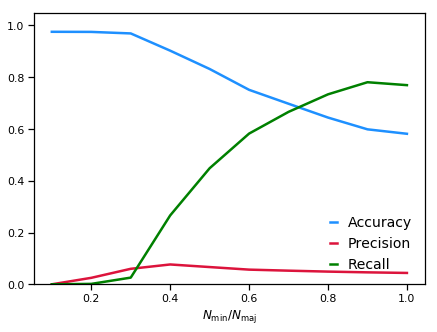

In [28]:
us = under_sampling.RandomUnderSampler
clf = svm.SVC(gamma='scale', C=50) 
rat, acc, pre, rec = resample_test(us, clf)

#### Random Oversampling

We use the simple oversampling strategy wherein we boost the number of samples in the minority class (BB100 hits) to bring the ratio of majority to minority class to a number closer to 1 instead of e.g., 100. 

We no longer have loss of information, but a new disadvantage is the potential to overfit since we are simply duplicating the minority class samples.

/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


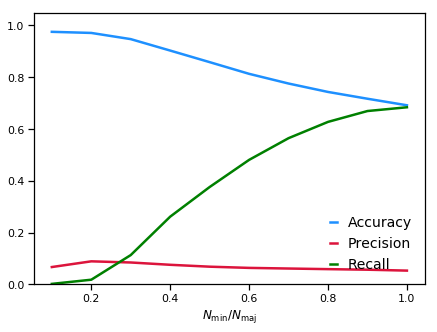

In [29]:
osam = over_sampling.RandomOverSampler
clf = xgboost.XGBClassifier()
rat, acc, pre, rec = resample_test(osam, clf)

#### SMOTE (Synthetic Minority Oversampling TEchnique)

We use a more sophisticated strategy to boost the number of samples in the minority class. Rather than simply copying repeatedly the few existing minority class sample, we generate new data that are representative of the minority class. From the existing minority sample, we choose k number of neighbors from which we synthesize N new data that lie somewhere between these points (i.e., interpolation).

Since SMOTE introduces some randomness to the newly sampled minority class, this helps to combat overfitting.

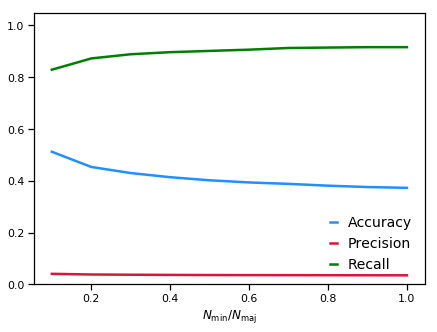

In [30]:
smt = over_sampling.SMOTE
clf = naive_bayes.GaussianNB()
rat, acc, pre, rec = resample_test(smt, clf)

#### ADASYN (ADAptive SYNthetic) 

We will check one more oversampling strategy which is a close cousin of SMOTE, with one importance difference. ADASYN uses the density distribution of the minority class to automatically choose the number of new synthetic samples created per existing minority sample. The overall effect is that ADASYN generates more synthetic samples for minority class samples that are difficult to learn, e.g., near the decision boundary. In comparison, in SMOTE, equal numbers of synthetic samples are created for each existing, original minority sample).

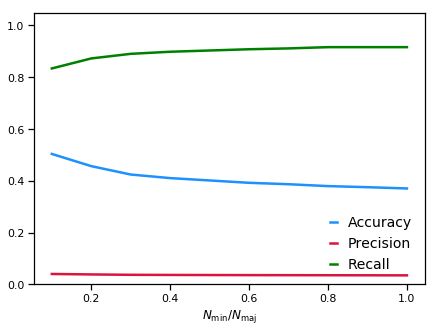

In [31]:
adas = over_sampling.ADASYN
clf = naive_bayes.GaussianNB()
rat, acc, pre, rec = resample_test(adas, clf)

*The resampling method we end up choosing depends on the algorithm and our priorities.* We see some trade-off between precision and recall, so the question is: do we want to maximize precision or recall? High precision and low recall means we are prioritizing our ability to correctly predict songs that really are hits, even if it means we might let some hits slip through the cracks due to our conservative approach. Low precision and high recall means we will generally predict more songs to be hits even if some of those end up to be inaccurate predictions. 

This type of precision-recall trade-off must be carefully thought through depending on the context: with fatal disease screening, doctors would probably err on the side of low precision and high recall since they would want to make sure that they catch more positive results even if some of those do end up being false positives.

## Training the Model

Use nested CV to optimize the hyperparameters and evaluate the performance of the model.

- Gaussian Naive Bayes
- Logistic Regression
- Support Vector Classifier (*SVC with Gaussian rbf might be good here. We initially tried this, but as expected, computational time is too long for a sample size this large. KNN also suffers from a performance issue.*)
- Random Forest Classifier
- XGBoost

### Nested Cross-Validation

*One possibility is to repeat this multiple times and aggregate the scores over all repetitions, which helps to yield a more robust evaluation of the models.

In [32]:
model_list = {"LR":linear_model.LogisticRegression(),\
              "NB": naive_bayes.GaussianNB(),"XGB":xgboost.XGBClassifier(),\
              "RFC": ensemble.RandomForestClassifier()}

In [33]:
num_feat = len(orig_train_X.columns)

#sometimes the recall/precision score are 0 and f1 is undefined
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

model_list = {"LR":linear_model.LogisticRegression(),\
              "NB": naive_bayes.GaussianNB(),"XGB":xgboost.XGBClassifier(),\
              "RFC": ensemble.RandomForestClassifier()}

params = {"NB":{'var_smoothing': pow(10,np.linspace(-12,-6,30))},\
          "LR":{'C': pow(10,np.linspace(-4,2,30)),\
                'penalty': ['l1', 'l2'],\
                'solver':['saga'],\
                'max_iter': [5000]},\
          "RFC":{"n_estimators": np.arange(100,201,5),\
                 "criterion": ['gini', 'entropy'],\
                 "max_depth": np.arange(2,11,2),\
                 "min_samples_split": np.arange(2,21,2),\
                 "min_samples_leaf": np.arange(1,21,2),\
                 "max_features": np.arange(2,num_feat+1),\
                 "min_impurity_decrease": np.append(0,pow(10,np.linspace(-4,0.5,29)))},\
          "XGB":{"learning_rate": pow(10,np.linspace(-3,-0.7,29)),\
                 "min_child_weight": np.arange(1,11,2),\
                 "max_depth": np.arange(2,11,2),\
                 "n_estimators": np.arange(100,201,5), 
                 "gamma": np.append(0,pow(10,np.linspace(-4,0.5,29))),\
                 "subsample": pow(10,np.linspace(-0.7,0,30)),\
                 "reg_lambda": pow(10,np.linspace(-2,0.5,30)),\
                 "reg_alpha": pow(10,np.linspace(-2,0.5,30))},\
         }

resam_list = {'US3':under_sampling.RandomUnderSampler(sampling_strategy=0.3),\
              'US5':under_sampling.RandomUnderSampler(sampling_strategy=0.5),\
              'US7':under_sampling.RandomUnderSampler(sampling_strategy=0.7),\
              'US10':under_sampling.RandomUnderSampler(sampling_strategy=1.0),\
              'SMOTE3': over_sampling.SMOTE(sampling_strategy=0.3),\
              'SMOTE5': over_sampling.SMOTE(sampling_strategy=0.5),\
              'SMOTE7': over_sampling.SMOTE(sampling_strategy=0.7),\
              'SMOTE10': over_sampling.SMOTE(sampling_strategy=1.0)}

score_dict = {}

for i_m, m in enumerate(model_list.keys()):
    
    for i_r, r in enumerate(resam_list.keys()):
    
        outer_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
        inner_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
        
        print('-'*40)
        print("{:-^40}".format(m))
        print("{:-^40}".format(r))
        print('-'*40)
              
        #inner CV to optimize, resampling has to be done during this inner loop
        res = resam_list[r]
        if (m == 'NB')|(m == 'LR'):
            clf = model_selection.GridSearchCV(model_list[m], params[m], \
                                                     n_jobs=-1, refit=True, iid=False, \
                                                     cv=inner_cv, scoring='neg_log_loss', verbose=True)
        else:
            clf = model_selection.RandomizedSearchCV(model_list[m], params[m], \
                                                     n_iter=100, n_jobs=-1, refit=True, iid=False, \
                                                     cv=inner_cv, scoring='neg_log_loss', verbose=True)
        pipe = imb_make_pipeline(res, clf)
    
        #outer CV to compute the score. 
        #this syntax passes the "training fold" from this 5-fold CV to RandomizedSearchCV
        scoring = {'acc': 'accuracy', 'pre': 'precision', 'rec': 'recall', 'f1': 'f1'}
        scores = model_selection.cross_validate(pipe, orig_train_X.values, orig_train_y.values, cv=outer_cv, scoring=scoring, return_train_score=False)
        
        score_dict[m+'_'+r] = scores
        
        print('{:<20}'.format('Training Time:')+'{:5.3f}'.format(np.mean(scores['fit_time']))+'+/-'+'{:5.3f}'.format(np.std(scores['fit_time'])))
        print('{:<20}'.format('Testing Time:')+'{:5.3f}'.format(np.mean(scores['score_time']))+'+/-'+'{:5.3f}'.format(np.std(scores['score_time'])))
        print('{:<20}'.format('Accuracy:')+'{:5.3f}'.format(np.mean(scores['test_acc']))+'+/-'+'{:5.3f}'.format(np.std(scores['test_acc'])))
        print('{:<20}'.format('Precision:')+'{:5.3f}'.format(np.mean(scores['test_pre']))+'+/-'+'{:5.3f}'.format(np.std(scores['test_pre'])))
        print('{:<20}'.format('Recall:')+'{:5.3f}'.format(np.mean(scores['test_rec']))+'+/-'+'{:5.3f}'.format(np.std(scores['test_rec'])))
        print('{:<20}'.format('F1 Score:')+'{:5.3f}'.format(np.mean(scores['test_f1']))+'+/-'+'{:5.3f}'.format(np.std(scores['test_f1'])))
          

----------------------------------------
-------------------LR-------------------
------------------US3-------------------
----------------------------------------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      4.021+/-0.157
Testing Time:       0.005+/-0.000
Accuracy:           0.952+/-0.002
Precision:          0.086+/-0.027
Recall:             0.102+/-0.039
F1 Score:           0.093+/-0.031
----------------------------------------
-------------------LR-------------------
------------------US5-------------------
----------------------------------------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      3.073+/-0.197
Testing Time:       0.005+/-0.000
Accuracy:           0.872+/-0.015
Precision:          0.066+/-0.010
Recall:             0.316+/-0.038
F1 Score:           0.109+/-0.015
----------------------------------------
-------------------LR-------------------
------------------US7-------------------
----------------------------------------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      2.023+/-0.172
Testing Time:       0.005+/-0.001
Accuracy:           0.755+/-0.010
Precision:          0.056+/-0.005
Recall:             0.569+/-0.053
F1 Score:           0.102+/-0.008
----------------------------------------
-------------------LR-------------------
------------------US10------------------
----------------------------------------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      1.836+/-0.171
Testing Time:       0.005+/-0.001
Accuracy:           0.596+/-0.014
Precision:          0.045+/-0.002
Recall:             0.771+/-0.040
F1 Score:           0.086+/-0.004
----------------------------------------
-------------------LR-------------------
-----------------SMOTE3-----------------
----------------------------------------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:   11.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 191 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.6s finished


Training Time:      10.593+/-0.878
Testing Time:       0.004+/-0.000
Accuracy:           0.942+/-0.004
Precision:          0.081+/-0.020
Recall:             0.129+/-0.035
F1 Score:           0.099+/-0.025
----------------------------------------
-------------------LR-------------------
-----------------SMOTE5-----------------
----------------------------------------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.3s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.9s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.4s finished


Training Time:      12.093+/-0.802
Testing Time:       0.004+/-0.000
Accuracy:           0.851+/-0.006
Precision:          0.066+/-0.011
Recall:             0.385+/-0.064
F1 Score:           0.112+/-0.019
----------------------------------------
-------------------LR-------------------
-----------------SMOTE7-----------------
----------------------------------------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.8s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.1s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.5s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.4s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.2s finished


Training Time:      13.865+/-0.399
Testing Time:       0.005+/-0.001
Accuracy:           0.749+/-0.005
Precision:          0.055+/-0.006
Recall:             0.571+/-0.066
F1 Score:           0.101+/-0.012
----------------------------------------
-------------------LR-------------------
----------------SMOTE10-----------------
----------------------------------------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.5s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.1s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.1s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.7s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.6s finished


Training Time:      16.689+/-0.472
Testing Time:       0.004+/-0.000
Accuracy:           0.625+/-0.007
Precision:          0.047+/-0.002
Recall:             0.737+/-0.039
F1 Score:           0.088+/-0.003
----------------------------------------
-------------------NB-------------------
------------------US3-------------------
----------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      0.227+/-0.018
Testing Time:       0.010+/-0.003
Accuracy:           0.414+/-0.021
Precision:          0.036+/-0.001
Recall:             0.898+/-0.027
F1 Score:           0.070+/-0.001
----------------------------------------
-------------------NB-------------------
------------------US5-------------------
----------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished


Training Time:      0.211+/-0.025
Testing Time:       0.008+/-0.002
Accuracy:           0.383+/-0.016
Precision:          0.035+/-0.001
Recall:             0.916+/-0.023
F1 Score:           0.068+/-0.001
----------------------------------------
-------------------NB-------------------
------------------US7-------------------
----------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Training Time:      0.186+/-0.004
Testing Time:       0.007+/-0.001
Accuracy:           0.366+/-0.013
Precision:          0.035+/-0.001
Recall:             0.927+/-0.019
F1 Score:           0.067+/-0.001
----------------------------------------
-------------------NB-------------------
------------------US10------------------
----------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      0.192+/-0.012
Testing Time:       0.007+/-0.000
Accuracy:           0.346+/-0.012
Precision:          0.034+/-0.001
Recall:             0.939+/-0.018
F1 Score:           0.066+/-0.001
----------------------------------------
-------------------NB-------------------
-----------------SMOTE3-----------------
----------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      0.983+/-0.016
Testing Time:       0.008+/-0.001
Accuracy:           0.430+/-0.018
Precision:          0.037+/-0.001
Recall:             0.881+/-0.019
F1 Score:           0.070+/-0.001
----------------------------------------
-------------------NB-------------------
-----------------SMOTE5-----------------
----------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      1.115+/-0.011
Testing Time:       0.008+/-0.001
Accuracy:           0.399+/-0.014
Precision:          0.036+/-0.001
Recall:             0.906+/-0.014
F1 Score:           0.069+/-0.001
----------------------------------------
-------------------NB-------------------
-----------------SMOTE7-----------------
----------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      1.251+/-0.022
Testing Time:       0.009+/-0.001
Accuracy:           0.387+/-0.011
Precision:          0.035+/-0.001
Recall:             0.911+/-0.018
F1 Score:           0.068+/-0.001
----------------------------------------
-------------------NB-------------------
----------------SMOTE10-----------------
----------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training Time:      1.604+/-0.213
Testing Time:       0.007+/-0.000
Accuracy:           0.371+/-0.010
Precision:          0.035+/-0.000
Recall:             0.923+/-0.020
F1 Score:           0.067+/-0.001
----------------------------------------
------------------XGB-------------------
------------------US3-------------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   45.4s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.8s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.4s finished


Training Time:      42.445+/-2.086
Testing Time:       0.094+/-0.021
Accuracy:           0.931+/-0.008
Precision:          0.082+/-0.015
Recall:             0.173+/-0.017
F1 Score:           0.111+/-0.017
----------------------------------------
------------------XGB-------------------
------------------US5-------------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.1s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 231 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 481 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.0s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.5s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.9s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.8s finished


Training Time:      27.983+/-1.041
Testing Time:       0.165+/-0.062
Accuracy:           0.825+/-0.008
Precision:          0.061+/-0.008
Recall:             0.426+/-0.051
F1 Score:           0.107+/-0.014
----------------------------------------
------------------XGB-------------------
------------------US7-------------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.4s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.9s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.8s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.6s finished


Training Time:      23.903+/-1.105
Testing Time:       0.151+/-0.051
Accuracy:           0.742+/-0.011
Precision:          0.056+/-0.004
Recall:             0.603+/-0.043
F1 Score:           0.103+/-0.008
----------------------------------------
------------------XGB-------------------
------------------US10------------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.4s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.2s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.0s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.4s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.3s finished


Training Time:      18.197+/-0.540
Testing Time:       0.118+/-0.036
Accuracy:           0.632+/-0.019
Precision:          0.048+/-0.001
Recall:             0.750+/-0.042
F1 Score:           0.091+/-0.002
----------------------------------------
------------------XGB-------------------
-----------------SMOTE3-----------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.9min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.0min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.7min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.2min finished


Training Time:      560.350+/-38.991
Testing Time:       0.365+/-0.065
Accuracy:           0.948+/-0.004
Precision:          0.053+/-0.021
Recall:             0.068+/-0.028
F1 Score:           0.059+/-0.024
----------------------------------------
------------------XGB-------------------
-----------------SMOTE5-----------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.9min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.7min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.1min finished


Training Time:      585.206+/-27.231
Testing Time:       0.367+/-0.072
Accuracy:           0.937+/-0.006
Precision:          0.046+/-0.010
Recall:             0.082+/-0.029
F1 Score:           0.058+/-0.015
----------------------------------------
------------------XGB-------------------
-----------------SMOTE7-----------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.8min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.7min finished


Training Time:      683.600+/-19.137
Testing Time:       0.346+/-0.044
Accuracy:           0.929+/-0.006
Precision:          0.045+/-0.008
Recall:             0.092+/-0.015
F1 Score:           0.060+/-0.009
----------------------------------------
------------------XGB-------------------
----------------SMOTE10-----------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.8min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.0min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.4min finished


Training Time:      824.900+/-54.898
Testing Time:       0.395+/-0.078
Accuracy:           0.921+/-0.005
Precision:          0.045+/-0.006
Recall:             0.108+/-0.008
F1 Score:           0.063+/-0.007
----------------------------------------
------------------RFC-------------------
------------------US3-------------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.1s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.4s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.7s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.3s finished


Training Time:      39.075+/-0.758
Testing Time:       0.251+/-0.041
Accuracy:           0.944+/-0.014
Precision:          0.067+/-0.022
Recall:             0.095+/-0.036
F1 Score:           0.077+/-0.026
----------------------------------------
------------------RFC-------------------
------------------US5-------------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.4s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.8s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.3s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.9s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.0s finished


Training Time:      34.040+/-1.674
Testing Time:       0.283+/-0.034
Accuracy:           0.821+/-0.020
Precision:          0.063+/-0.006
Recall:             0.448+/-0.058
F1 Score:           0.110+/-0.011
----------------------------------------
------------------RFC-------------------
------------------US7-------------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.0s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.2s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.0s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.8s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.6s finished


Training Time:      29.634+/-1.291
Testing Time:       0.262+/-0.046
Accuracy:           0.732+/-0.015
Precision:          0.056+/-0.004
Recall:             0.619+/-0.035
F1 Score:           0.102+/-0.008
----------------------------------------
------------------RFC-------------------
------------------US10------------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.4s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.6s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.2s finished


Training Time:      26.823+/-1.015
Testing Time:       0.266+/-0.019
Accuracy:           0.608+/-0.006
Precision:          0.046+/-0.001
Recall:             0.768+/-0.025
F1 Score:           0.088+/-0.003
----------------------------------------
------------------RFC-------------------
-----------------SMOTE3-----------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.5min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.5min finished


Training Time:      368.895+/-30.218
Testing Time:       0.271+/-0.063
Accuracy:           0.925+/-0.013
Precision:          0.066+/-0.009
Recall:             0.156+/-0.036
F1 Score:           0.092+/-0.012
----------------------------------------
------------------RFC-------------------
-----------------SMOTE5-----------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.4min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.0min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.6min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.1min finished


Training Time:      467.891+/-39.053
Testing Time:       0.296+/-0.059
Accuracy:           0.835+/-0.011
Precision:          0.058+/-0.005
Recall:             0.377+/-0.053
F1 Score:           0.100+/-0.009
----------------------------------------
------------------RFC-------------------
-----------------SMOTE7-----------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.7min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.7min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.0min finished


Training Time:      582.993+/-46.542
Testing Time:       0.240+/-0.050
Accuracy:           0.773+/-0.010
Precision:          0.056+/-0.004
Recall:             0.523+/-0.026
F1 Score:           0.101+/-0.007
----------------------------------------
------------------RFC-------------------
----------------SMOTE10-----------------
----------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.7min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.8min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.3min finished


Training Time:      719.583+/-70.061
Testing Time:       0.246+/-0.072
Accuracy:           0.713+/-0.017
Precision:          0.052+/-0.003
Recall:             0.621+/-0.014
F1 Score:           0.096+/-0.005


As we predicted, *this is a hard problem and the hits and non-hits aren't very well-separated in features, making the classification very challenging.*

In [34]:
scores_list = [v for v in score_dict.values()]
model_key_list = [k for k in score_dict.keys()]

In [35]:
sns.set_palette("Set2")

Text(0, 0.5, 'Validation Recall')

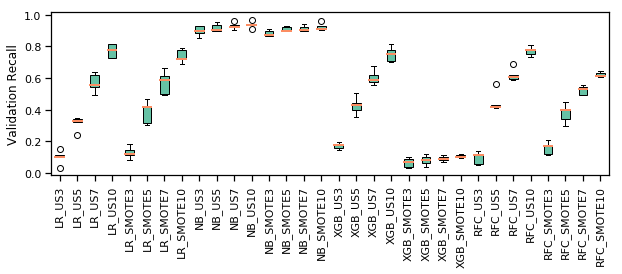

In [36]:
scores_list_rec = [x['test_rec'] for x in scores_list]
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
_ = plt.boxplot(scores_list_rec, patch_artist=True, medianprops={'linewidth':2.0})
_ = ax.set_xticklabels(model_key_list, rotation=90)
plt.ylabel('Validation Recall')

Text(0, 0.5, 'Validation Precision')

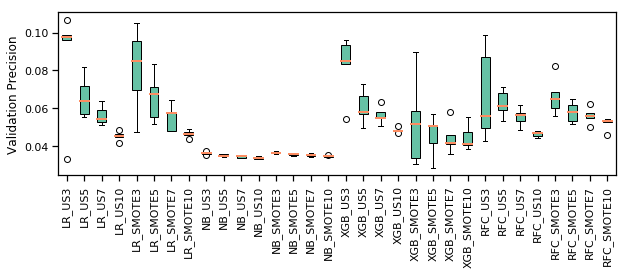

In [37]:
scores_list_pre = [x['test_pre'] for x in scores_list]
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
_ = plt.boxplot(scores_list_pre, patch_artist=True, medianprops={'linewidth':2.0})
_ = ax.set_xticklabels(model_key_list, rotation=90)
plt.ylabel('Validation Precision')

Text(0, 0.5, 'Validation F1')

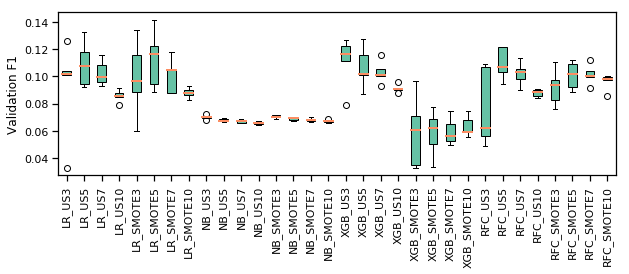

In [38]:
scores_list_f1 = [x['test_f1'] for x in scores_list]
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
_ = plt.boxplot(scores_list_f1, patch_artist=True, medianprops={'linewidth':2.0})
_ = ax.set_xticklabels(model_key_list, rotation=90)
plt.ylabel('Validation F1')

### Obtain the Final Model

We will continue and train with all of our training data with a selected model. A good score to maximize in an unbalanced classification problem is F1, the harmonic mean of precision and recall. However, given such low precision values across the board (the whole range of values is only between ~0.04 to 0.06), let's focus on prioritizing recall. This is equivalent to saying "I'm willing to tolerate non-hits incorrectly classified as hits (FP) so that I can minimize the risk of missing actual hits (FN)."

NB generally returns the highest recall, but we will proceed with the RFC+US10 model since it allows us to examine the feature importance.

In [39]:
#again, resample *during* the CV step on just the training set, so there is no info leak into the validation set
win_params = {"clf__n_estimators": np.arange(100,201,5),\
                 "clf__criterion": ['gini', 'entropy'],\
                 "clf__max_depth": np.arange(2,11,2),\
                 "clf__min_samples_split": np.arange(2,21,2),\
                 "clf__min_samples_leaf": np.arange(1,21,2),\
                 "clf__max_features": np.arange(2,num_feat+1),\
                 "clf__min_impurity_decrease": np.append(0,pow(10,np.linspace(-4,0.5,29)))}
win_res = under_sampling.RandomUnderSampler(sampling_strategy=1.0)
win_clf = ensemble.RandomForestClassifier()
pipeline = imblearn.pipeline.Pipeline([('res',win_res), ('clf', win_clf)])

skfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True)

final_clf = model_selection.RandomizedSearchCV(pipeline, win_params, n_jobs=-1, n_iter=100,\
                                         refit=True, iid=False, cv=skfold, scoring='neg_log_loss', verbose=True, return_train_score=True)

In [40]:
_ = final_clf.fit(orig_train_X, orig_train_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.9s finished


In [41]:
best_params = final_clf.best_params_
print(best_params)

{'clf__n_estimators': 200, 'clf__min_samples_split': 12, 'clf__min_samples_leaf': 11, 'clf__min_impurity_decrease': 0.0001, 'clf__max_features': 6, 'clf__max_depth': 6, 'clf__criterion': 'gini'}


In [42]:
pred_y = final_clf.predict(final_test_X)

In [43]:
save_clf = True
save_file = 'hitornot_tuned_model.joblib'
if save_clf:
    #if the file exists already, throw an error to prevent overwriting
    assert not os.path.isfile(save_file)
    dump(final_clf, save_file) 
else:
    final_clf = load(save_file) 
    pred_y = final_clf.predict(final_test_X)

Visualize the feature importance.

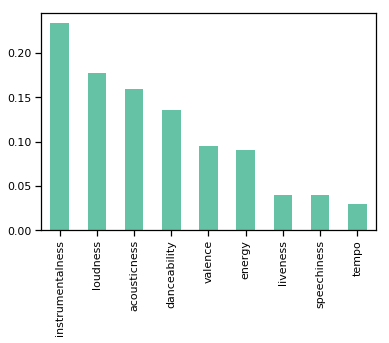

In [44]:
feat_imp = dict(zip(final_test_X.columns, final_clf.best_estimator_.steps[1][1].feature_importances_))
pd.Series(feat_imp).sort_values(ascending=False).plot.bar()

Visualizing random trees.

In [45]:
ntree = 10
export_graphviz(final_clf.best_estimator_.steps[1][1].estimators_[ntree], out_file='rfc'+str(ntree)+'.dot', 
                feature_names = final_test_X.columns,
                class_names = ['Not','Hit'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
os.system('dot -Tpng rfc'+str(ntree)+'.dot -o rfc'+str(ntree)+'.png')

0

### Examine the Results

In [46]:
print(metrics.classification_report(final_test_y, pred_y, digits=3, output_dict=False))

              precision    recall  f1-score   support

           0      0.993     0.596     0.745     10570
           1      0.049     0.827     0.093       266

   micro avg      0.602     0.602     0.602     10836
   macro avg      0.521     0.712     0.419     10836
weighted avg      0.970     0.602     0.729     10836



We score higher on the recall than precision, meaning we're less likely to miss actual hits, but we misclassify non-hits as hits about half the time. 

Text(0.5, 12.5, 'Predicted Hit')

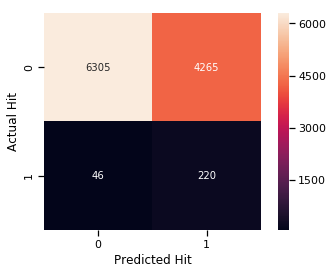

In [47]:
cm = metrics.confusion_matrix(final_test_y, pred_y)
ax = sns.heatmap(cm, square=True, annot=True, fmt="d")
ax.set_ylabel('Actual Hit')
ax.set_xlabel('Predicted Hit')

Examine the TP, FP, FN results to see if there's anything unusual about their features.

TP and FP have strongly overlapping distributions, which is not surprising: they share very similar characteristics and thus it is difficult to distinguish between the two categories.

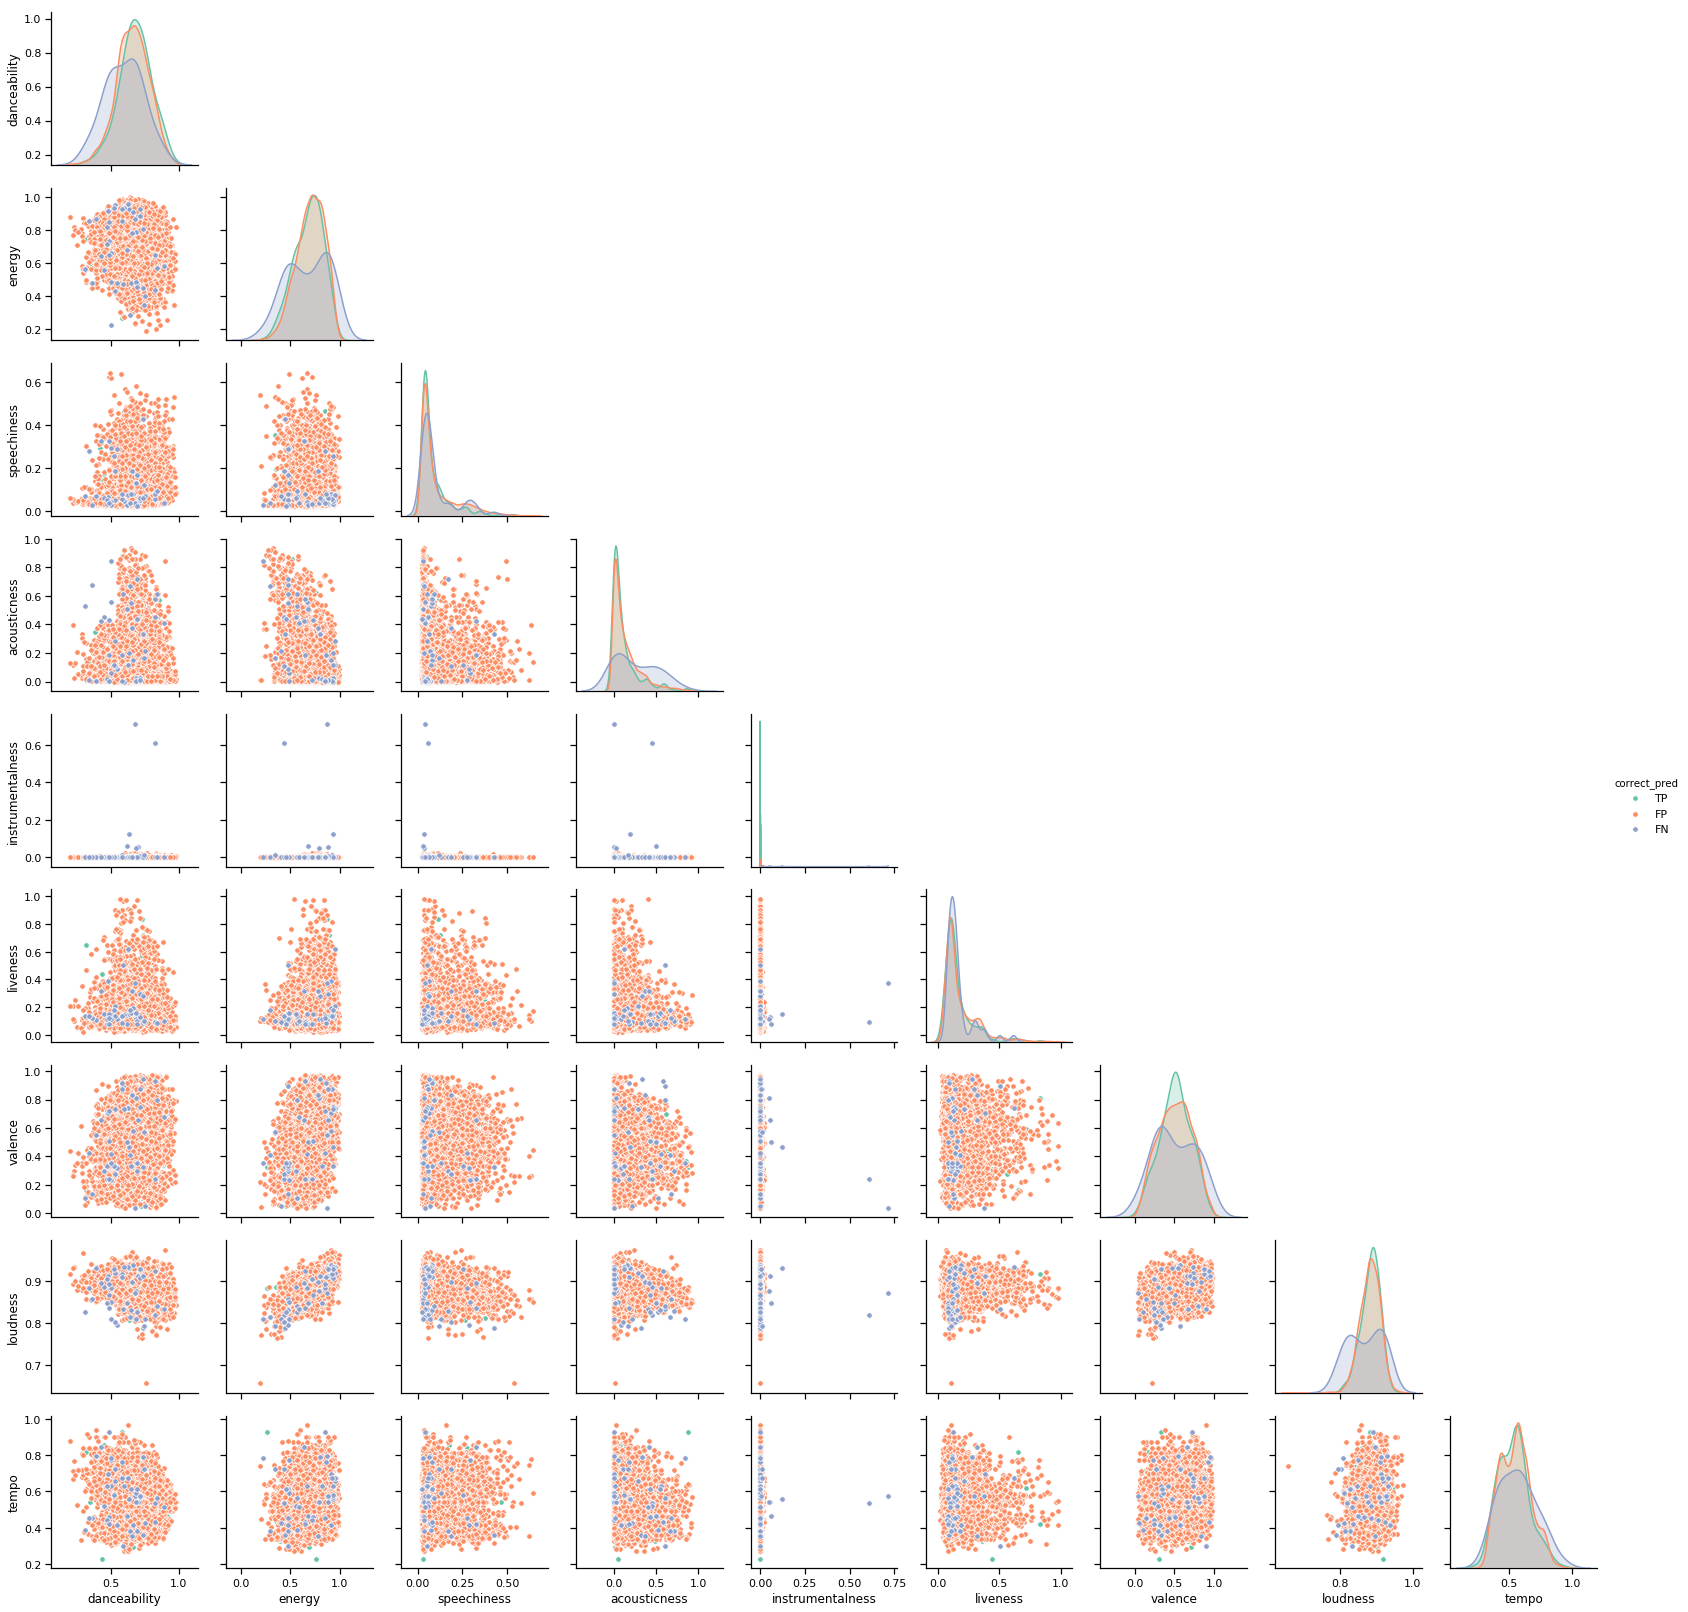

In [48]:
final_test_X_with_pred = final_test_X.copy()
final_test_X_with_pred = final_test_X_with_pred[~((pred_y==final_test_y)&(pred_y==0))]

pred_y_red = pred_y[~((pred_y==final_test_y)&(pred_y==0))]
test_y_red = final_test_y[~((pred_y==final_test_y)&(pred_y==0))]
                      
results_conditions = [((pred_y_red==1)&(test_y_red==0)), \
                      ((pred_y_red==0)&(test_y_red==1)), \
                      ((pred_y_red==1)&(test_y_red==1))]
results_choices = ['FP','FN','TP']

final_test_X_with_pred['correct_pred'] = np.select(results_conditions, results_choices)

s = sns.pairplot(final_test_X_with_pred, hue='correct_pred', plot_kws={"s": 30})
for i, j in zip(*np.triu_indices_from(s.axes, 1)):
    s.axes[i, j].set_visible(False)

## Conclusion

The goal of this project was to use Spotify's [audio features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) data to explore the characteristics of popular songs released between 2010 and 2018.

We first scraped data from the [Billboard archives](https://www.billboard.com/archive/charts) to obtain a list of hit songs and artists, then we looked up audio features for each of those songs. We also generated a pool of random songs, each with audio features data, to serve as the non-hits sample. 

We found that popular songs tended to be high-energy, highly danceable, generally non-acoustic and non-instrumental. We found a hint of evidence that popular songs are gradually moving away from the high-energy and high-valence end of the spectrum with time, which we should explore further. Interesting follow-up work will be to extend this analysis further back in time to other decades *and* to monitor the trends in the future.

We explored different resampling strategies using [imbalanced-learn](http://imbalanced-learn.org/en/stable/user_guide.html) then performed nested CV to assess model performance while simultaneously optimizing the hyperparameters. 

With just audio features alone, we cannot predict the popularity of a song very well, and we will be continuing this work to see if we can obtain additional features. A possibly useful feature is a measure of total album sales (or # song downloads) for an artist to date (e.g., artist's sales up until 2016 for a song released in 2016), though this would bias against new artists.